In [1]:
import GAN.models as models
import GAN.toy_datasets as toys
import GAN.plotting as plotting

Using Theano backend.


In [2]:
reload(toys)

# z,_ = toys.two_peaks(100000,split=False)
x,z = toys.three_peaks(500000,split=False)



In [3]:
c0 = np.random.uniform(-1,1,x.shape)+np.random.normal(0,0.1,x.shape)

# c0 = toys.two_peaks_target(x.shape[0])

def shift_cube(X):
    c,x = X
    val = (2.*c**3 - c**2)
    return  val + x
    #return x + c
    # return x + c + c**2

def shift_square(X):
    c,x = X
    val = (c + c**2)
    return  val + x

c0x = np.hstack([c0.reshape(-1,1),x.reshape(-1,1)])
c0z = np.hstack([c0.reshape(-1,1),x.reshape(-1,1)])
print(c0x.shape)
x_transform = np.apply_along_axis( shift_cube, 1,  c0x  ).reshape(x.shape)
#z_transform = np.apply_along_axis( shift, 1,  c0z  ).reshape(x.shape)
c_transform = c0 # + np.random.normal(0,0.1,c0.shape).reshape(x.shape)

x_transform -= x_transform.mean()
x_transform  /= x_transform.std()
c_transform -= c_transform.mean()
c_transform /= c_transform.std()

# x_train, x_test, c_train, c_test, z_train, z_test = toys.train_test_split( x_transform, c_transform, z )
x_train = x_transform
z_train = z
c_train = c_transform

probs_test = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]
c_quantiles = np.percentile(c_transform.ravel(),probs_test)

probs_test = probs_test[1:]
c_test = np.vstack( [c_quantiles[1:]]*len(probs_test) ).T.reshape(-1,1,1)


z_ravel = z.ravel()
z_test = np.vstack( [ np.percentile(z_ravel,probs_test) ]*len(probs_test) ).reshape(-1,1,1)

c_ravel = c_transform.ravel()
x_ravel = x_transform.ravel()
x_test = []
for iqt in range(c_quantiles.shape[0]-1):
    q0 = c_quantiles[iqt]
    q1 = c_quantiles[iqt+1]
    x_slice = x_ravel[(c_ravel>q0) & (c_ravel<=q1)] 
    x_test.append( np.percentile(x_slice,probs_test) )
x_test = np.vstack( x_test ).reshape(-1,1,1)


(500000, 2)


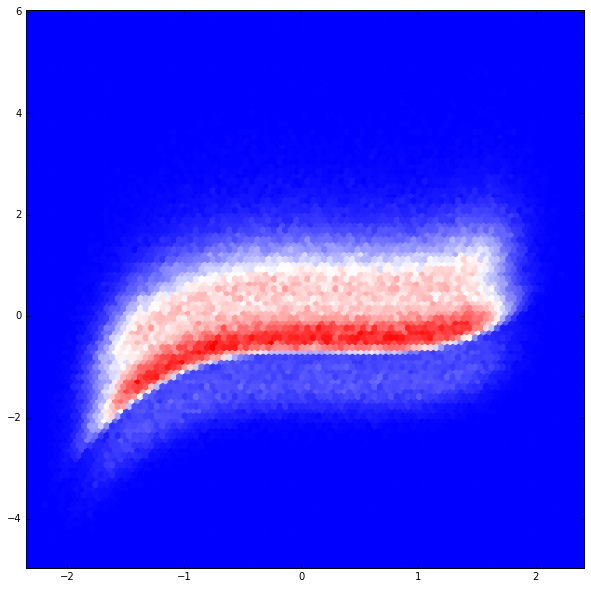

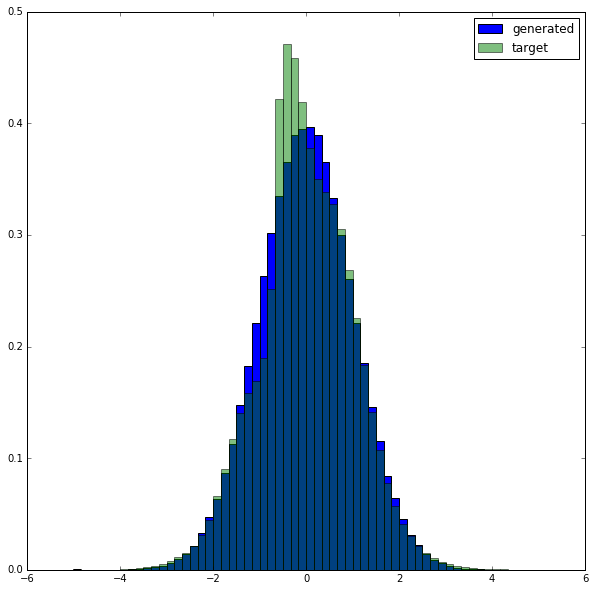

In [4]:
plt.hexbin( c_transform.ravel(), x_transform.ravel() )
plt.show()
plotting.plot_hists(x_transform.ravel(),z.ravel())#,range=[-4,10])

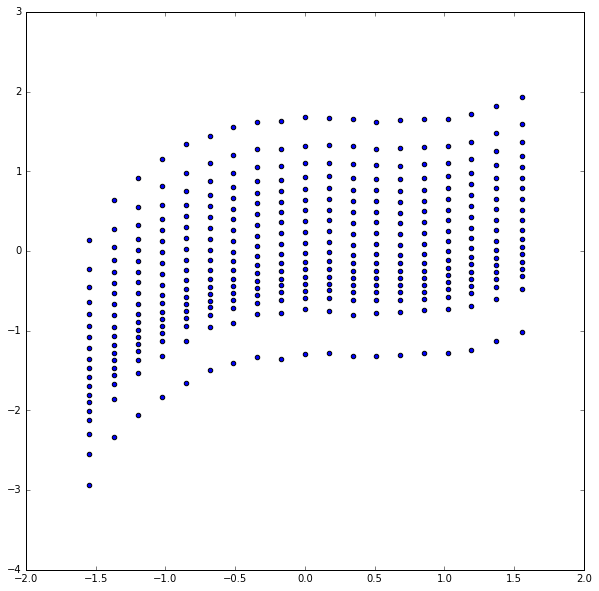

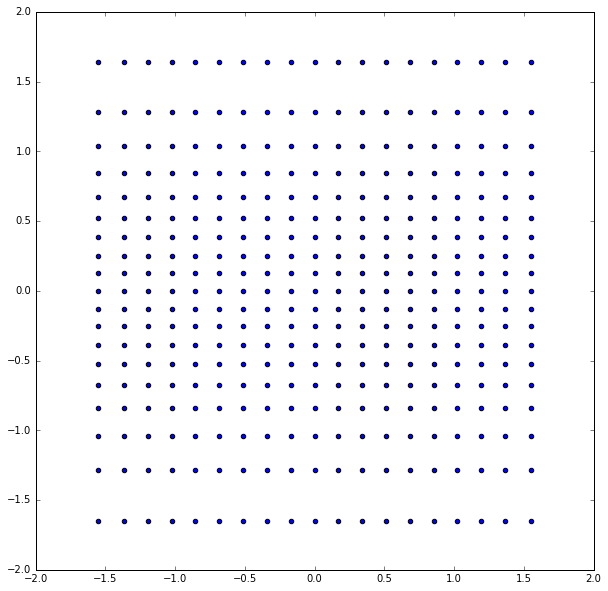

In [5]:
plt.scatter( c_test.ravel(), x_test.ravel() )
plt.show()
plt.scatter( c_test.ravel(), z_test.ravel() )
plt.show()


In [6]:
p = 0
c_test[p,0],x_test[p,0]-z_test[p,0]

(array([-1.55077103]), array([-1.2893262]))

In [7]:
reload(models)

gan = models.MyFFGAN( (1,1), (1,1), c_shape=(1,1),
                     g_opts=dict(name="G_32x3_64x3_128x3",kernel_sizes=[128]*3+[64]*3+[32]*3,#kernel_sizes=[128]*11,
#                                 do_nl_activ=[False,"tanh"]*3+[False],
#                                 do_poly=True,
#                                 do_nl_activ="relu",do_skip=False, do_bn=True
                                ),
                     d_opts=dict(name="D_512x5_tanh",kernel_sizes=[512]*5),
#                     dm_opts=dict(optimizer=models.Adam,opt_kwargs=dict(lr=1e-5)),
#                     am_opts=dict(optimizer=models.Adam,opt_kwargs=dict(lr=1e-5)),
                      dm_opts=dict(optimizer=models.RMSprop,opt_kwargs=dict(lr=0.0001, decay=6e-6)),
                      am_opts=dict(optimizer=models.RMSprop,opt_kwargs=dict(lr=0.0001, decay=6e-6)),

                    )

In [8]:
gan.get_generator()

(1, 1)


In [9]:
gan.get_discriminator()

In [10]:
gan.compile()

(<keras.engine.training.Model at 0x7f118dc3a590>,
 <keras.engine.training.Model at 0x7f118ddee310>)

In [11]:
gan.get_generator().summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
G_32x3_64x3_128x3_c_input (Input (None, 1, 1)          0                                            
____________________________________________________________________________________________________
G_32x3_64x3_128x3_input (InputLa (None, 1, 1)          0                                            
____________________________________________________________________________________________________
G_32x3_64x3_128x3_all_inputs (Co (None, 1, 2)          0           G_32x3_64x3_128x3_c_input[0][0]  
                                                                   G_32x3_64x3_128x3_input[0][0]    
____________________________________________________________________________________________________
G_32x3_64x3_128x3_up1_dense (Den (None, 1, 32)         96          G_32x3_64x3_128x3_all_in

In [12]:
gan.get_discriminator().summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
D_512x5_tanh_c_input (InputLayer (None, 1, 1)          0                                            
____________________________________________________________________________________________________
D_512x5_tanh_input (InputLayer)  (None, 1, 1)          0                                            
____________________________________________________________________________________________________
D_512x5_tanh_all_inputs (Concate (None, 1, 2)          0           D_512x5_tanh_c_input[0][0]       
                                                                   D_512x5_tanh_input[0][0]         
____________________________________________________________________________________________________
D_512x5_tanh_down1_dense (Dense) (None, 1, 512)        1536        D_512x5_tanh_all_inputs[

In [13]:
gan.am.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
G_32x3_64x3_128x3_c_input (Input (None, 1, 1)          0                                            
____________________________________________________________________________________________________
G_32x3_64x3_128x3_input (InputLa (None, 1, 1)          0                                            
____________________________________________________________________________________________________
G_32x3_64x3_128x3_all_inputs (Co (None, 1, 2)          0           G_32x3_64x3_128x3_c_input[0][0]  
                                                                   G_32x3_64x3_128x3_input[0][0]    
____________________________________________________________________________________________________
G_32x3_64x3_128x3_up1_dense (Den (None, 1, 32)         96          G_32x3_64x3_128x3_all_in

In [14]:
gan.dm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
D_512x5_tanh_c_input (InputLayer (None, 1, 1)          0                                            
____________________________________________________________________________________________________
D_512x5_tanh_input (InputLayer)  (None, 1, 1)          0                                            
____________________________________________________________________________________________________
D_512x5_tanh_all_inputs (Concate (None, 1, 2)          0           D_512x5_tanh_c_input[0][0]       
                                                                   D_512x5_tanh_input[0][0]         
____________________________________________________________________________________________________
D_512x5_tanh_down1_dense (Dense) (None, 1, 512)        1536        D_512x5_tanh_all_inputs[

In [15]:
# import GAN.toy_datasets as toys

In [16]:
# reload(toys)

# x_train,x_test,z_train,z_test = toys.two_peaks(100000) 

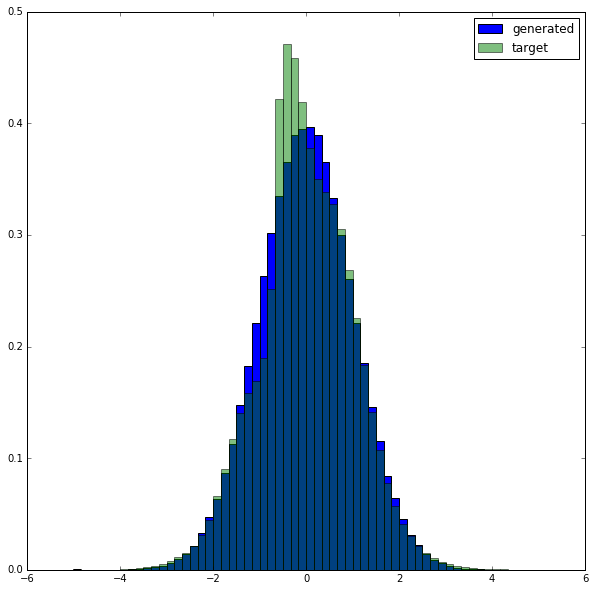

In [17]:
plotting.plot_hists(x_train.ravel(),z_train.ravel())

In [18]:
# reload(toys)

# x,z = toys.three_peaks(100000)

# plotting.plot_hists(x.ravel(),z.ravel())

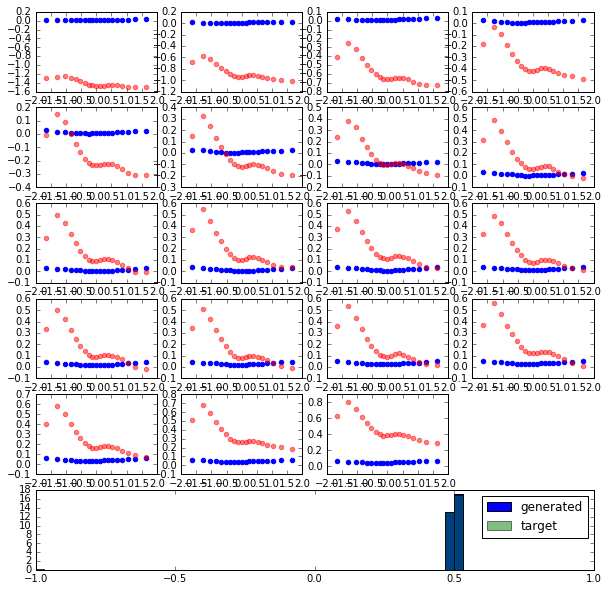

0: D [0.693016 0.503296] A: [0.696583 0.429443]


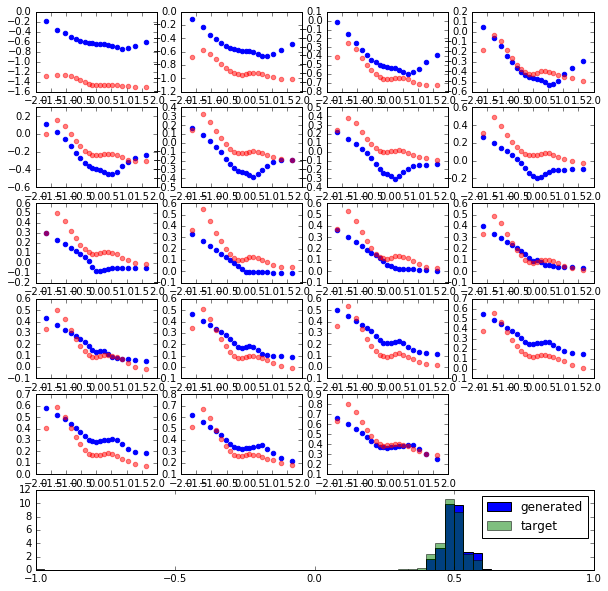

0: D [0.686601 0.535522] A: [0.709851 0.432617]


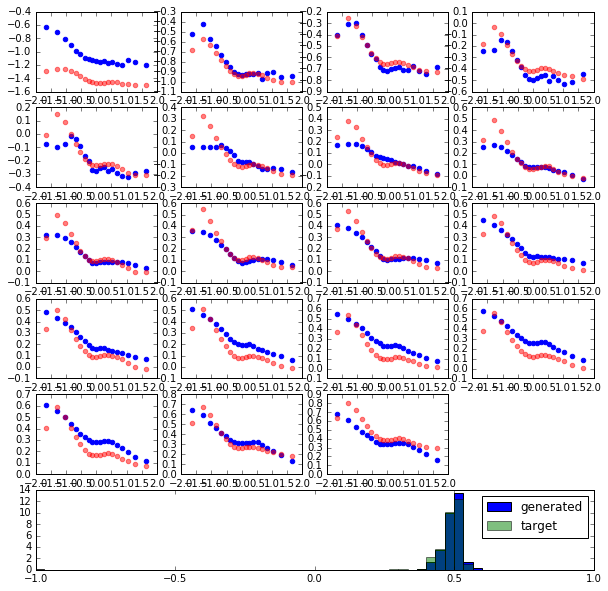

0: D [0.690538 0.532593] A: [0.729440 0.286865]


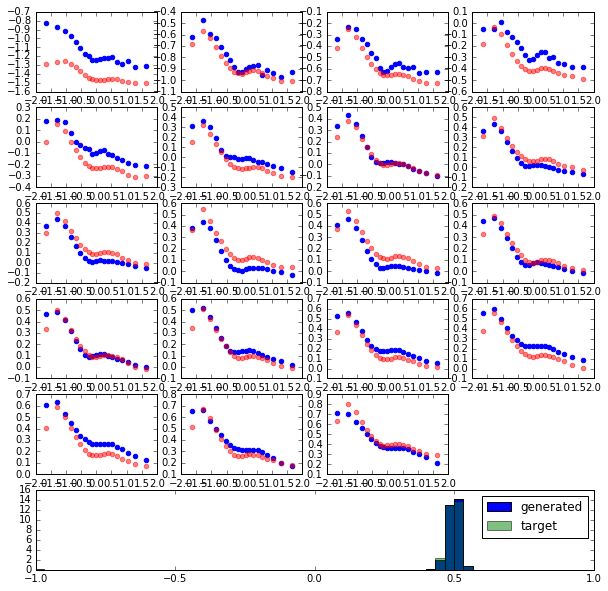

0: D [0.691733 0.519653] A: [0.707801 0.404785]


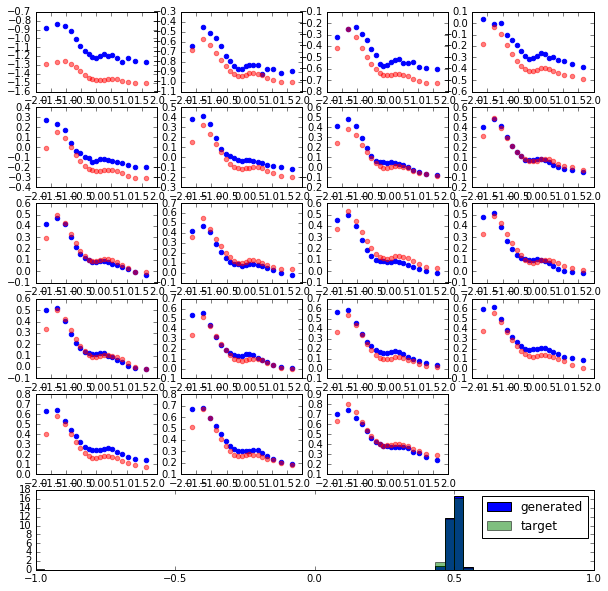

0: D [0.691942 0.527588] A: [0.695894 0.487061]


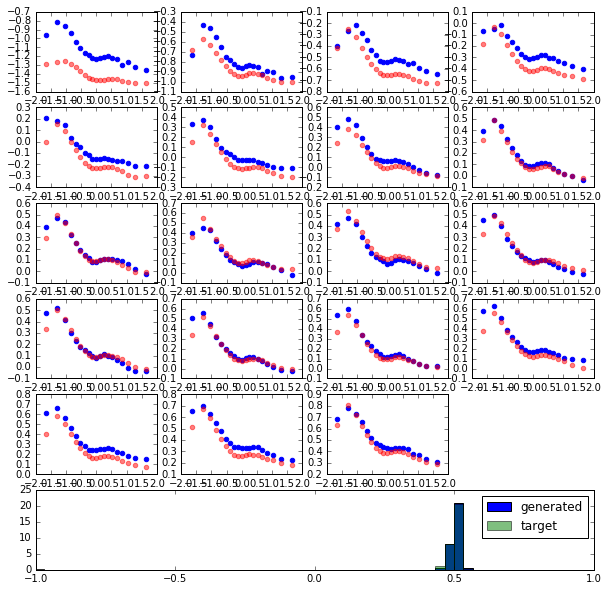

0: D [0.692309 0.515015] A: [0.691440 0.529541]


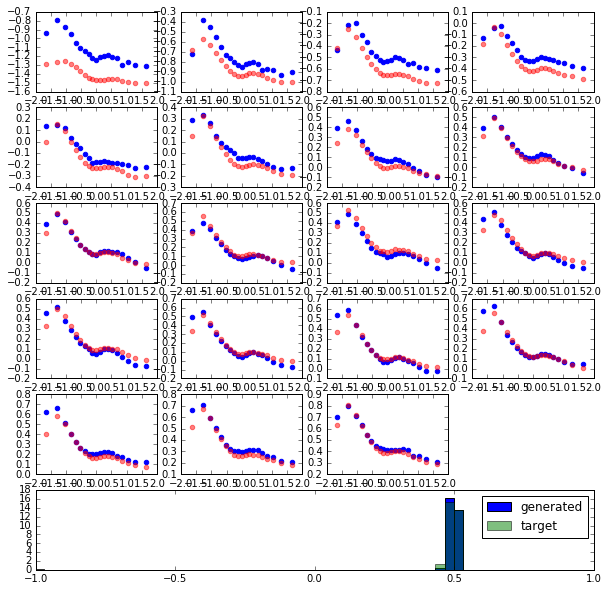

0: D [0.692802 0.508179] A: [0.700425 0.304199]


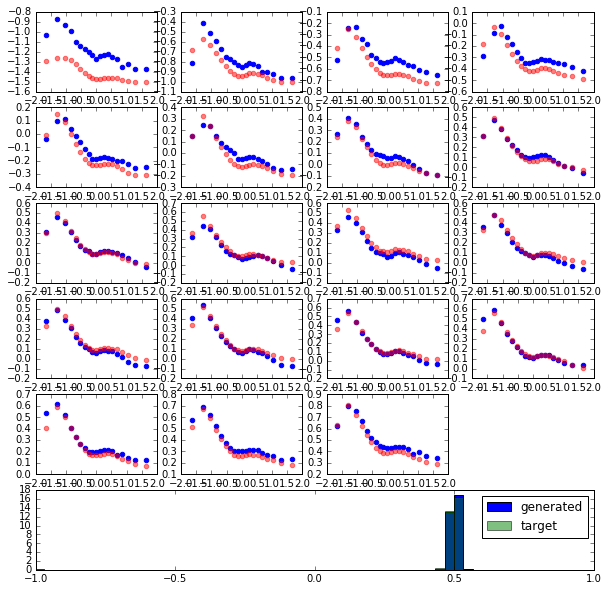

0: D [0.693317 0.505249] A: [0.698427 0.424316]


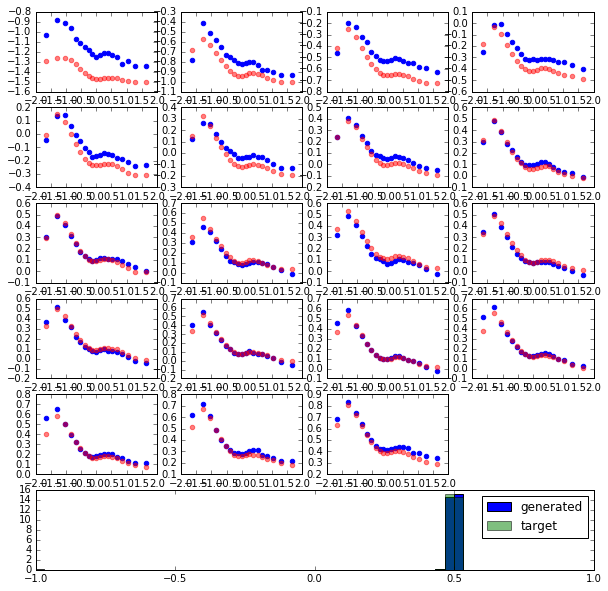

0: D [0.693152 0.499512] A: [0.696831 0.311279]


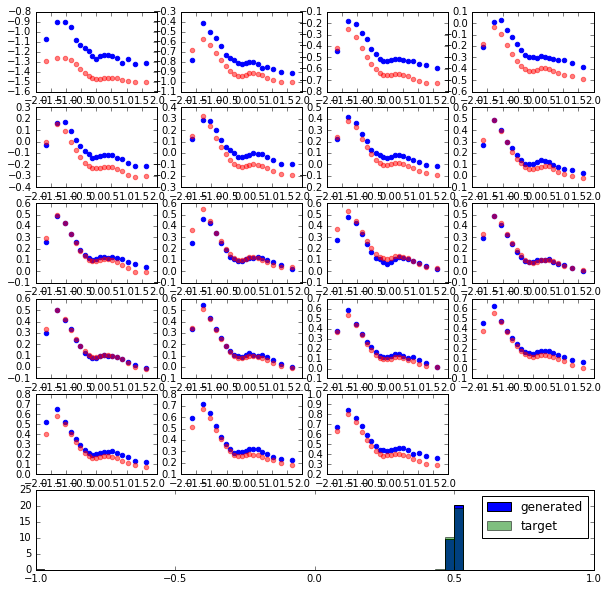

0: D [0.693107 0.507202] A: [0.694294 0.334229]


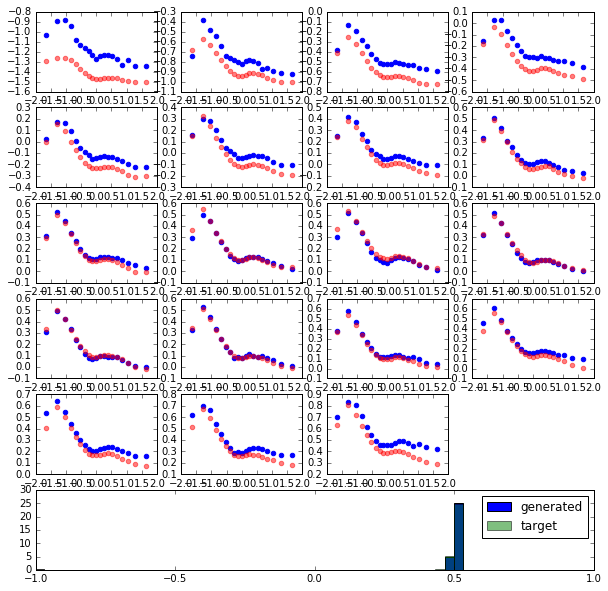

0: D [0.693000 0.509277] A: [0.693467 0.311035]


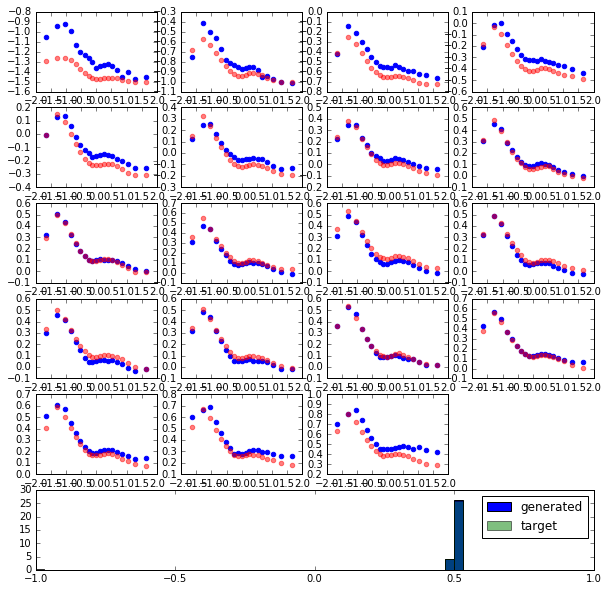

0: D [0.693045 0.510254] A: [0.691974 0.582520]


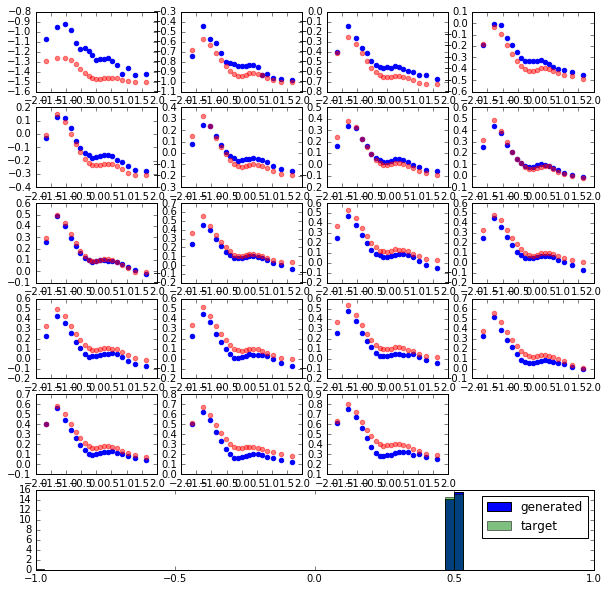

0: D [0.693192 0.505981] A: [0.691186 0.706299]


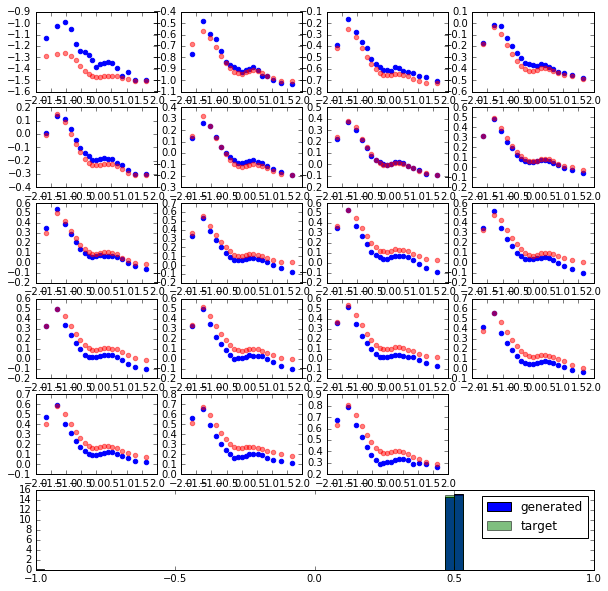

0: D [0.693212 0.497681] A: [0.693068 0.558838]


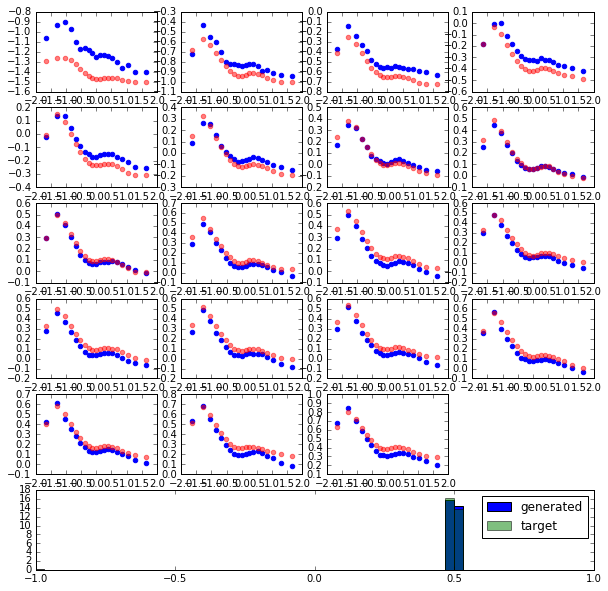

0: D [0.693214 0.491455] A: [0.692787 0.557861]


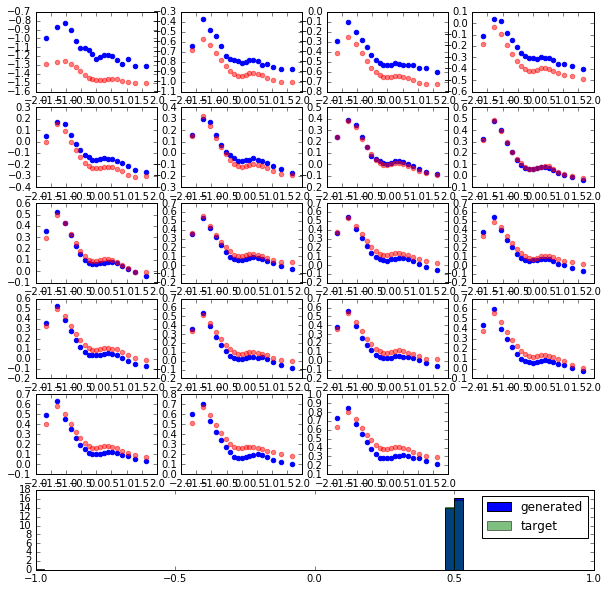

0: D [0.693188 0.496704] A: [0.693444 0.381104]


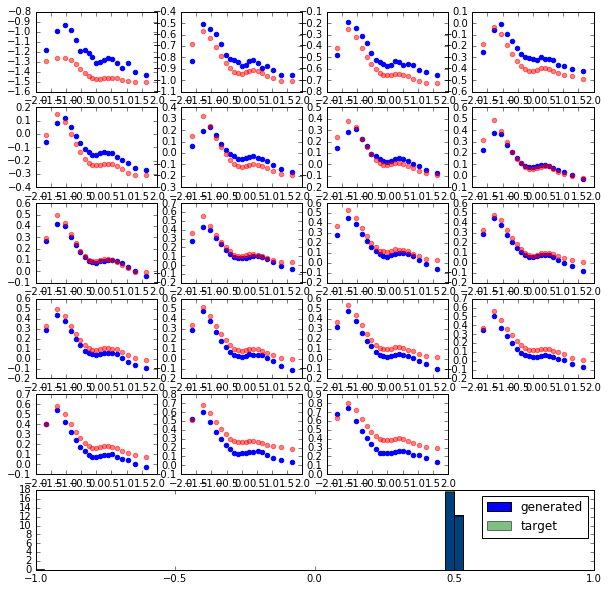

0: D [0.693175 0.497192] A: [0.692702 0.636963]


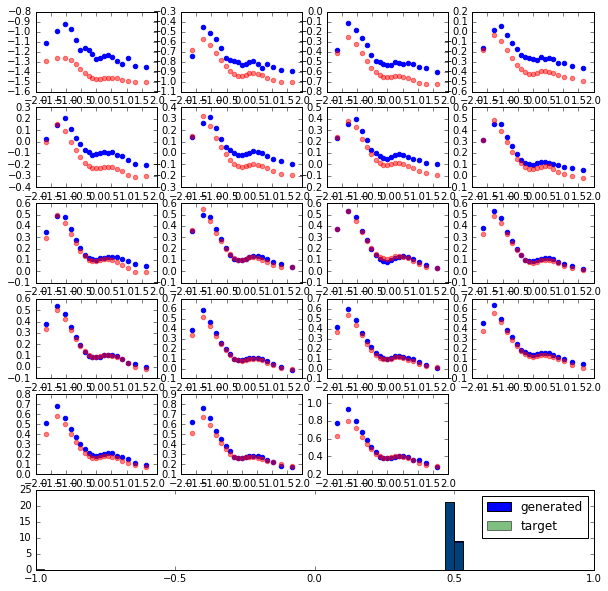

0: D [0.693167 0.494629] A: [0.693313 0.461426]


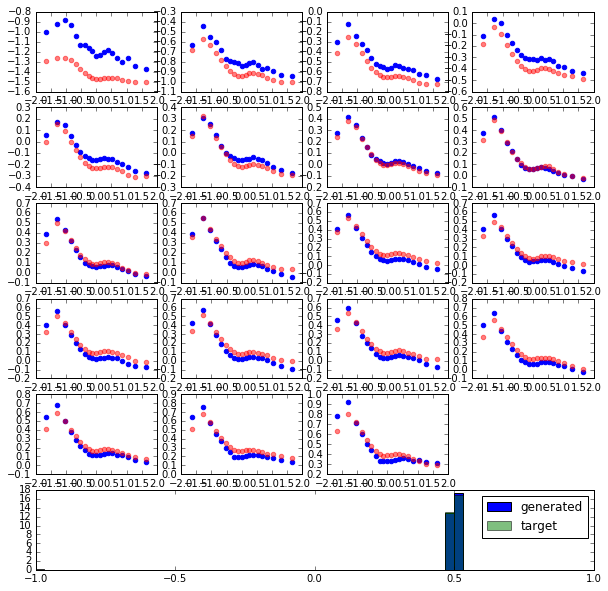

0: D [0.693173 0.493408] A: [0.693091 0.530762]


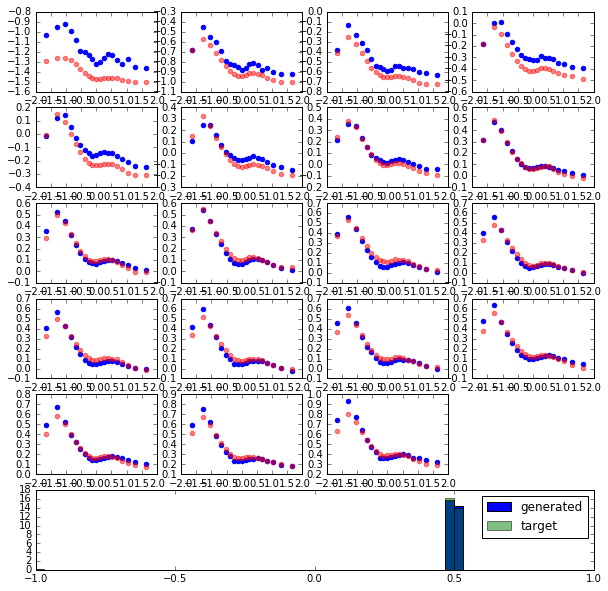

0: D [0.693150 0.498657] A: [0.693218 0.492432]


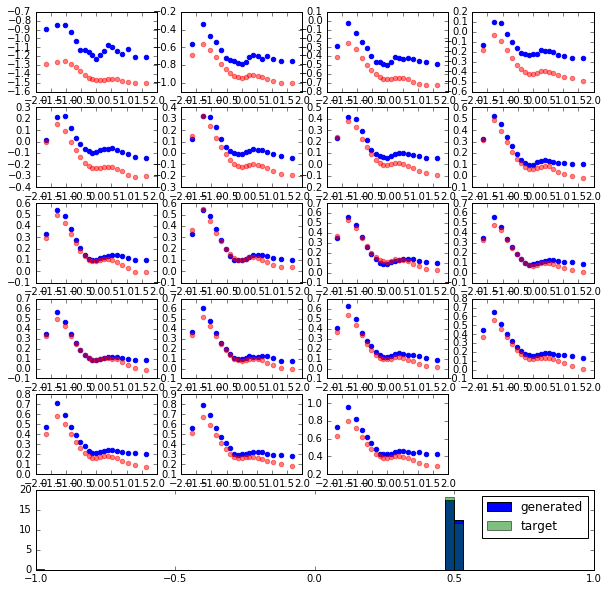

0: D [0.693106 0.503296] A: [0.693181 0.584961]


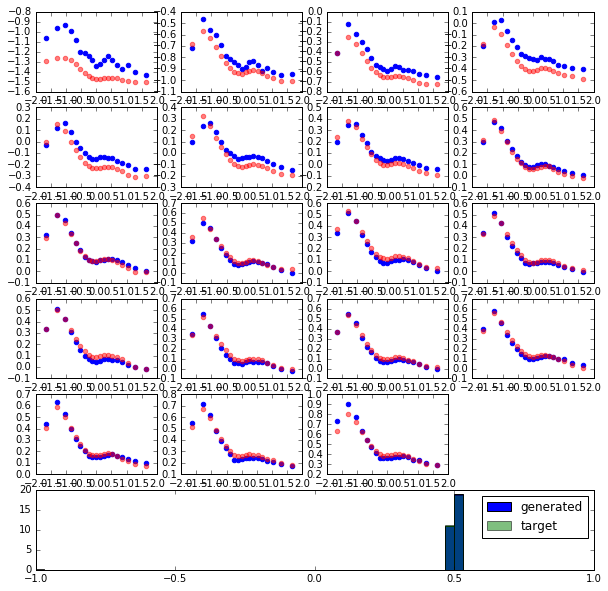

0: D [0.693090 0.504150] A: [0.693165 0.647461]


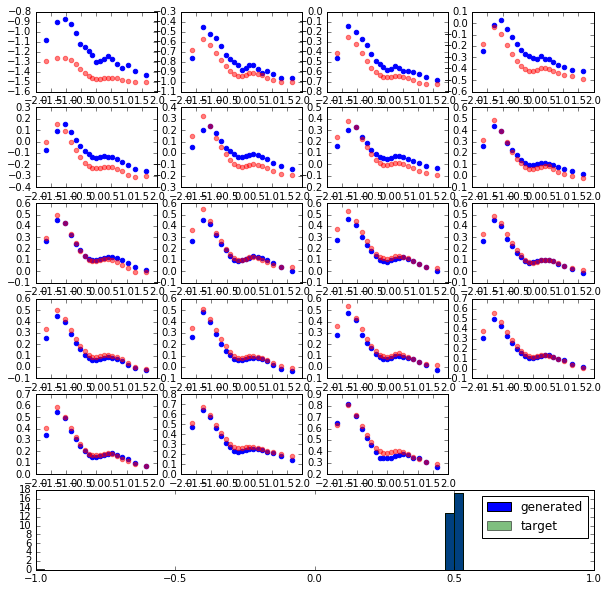

0: D [0.693099 0.505371] A: [0.692126 0.587646]


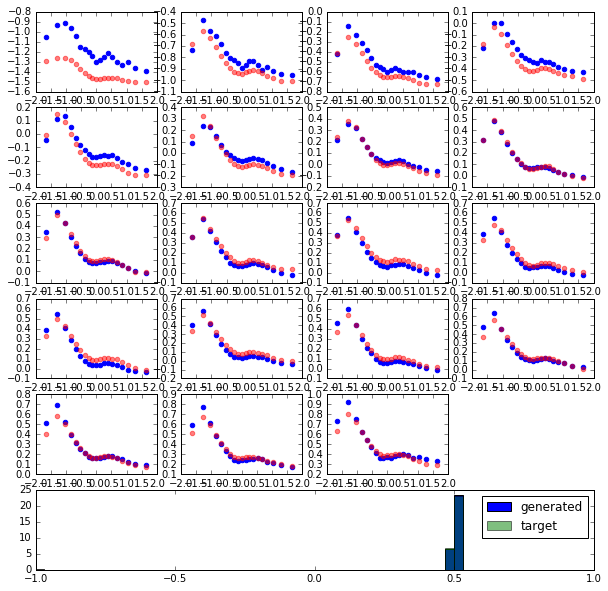

0: D [0.693118 0.503540] A: [0.691897 0.637207]


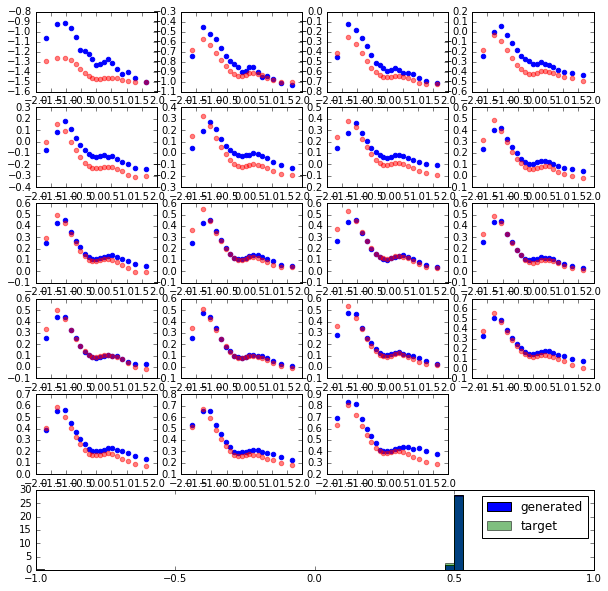

0: D [0.693162 0.496460] A: [0.691922 0.652588]


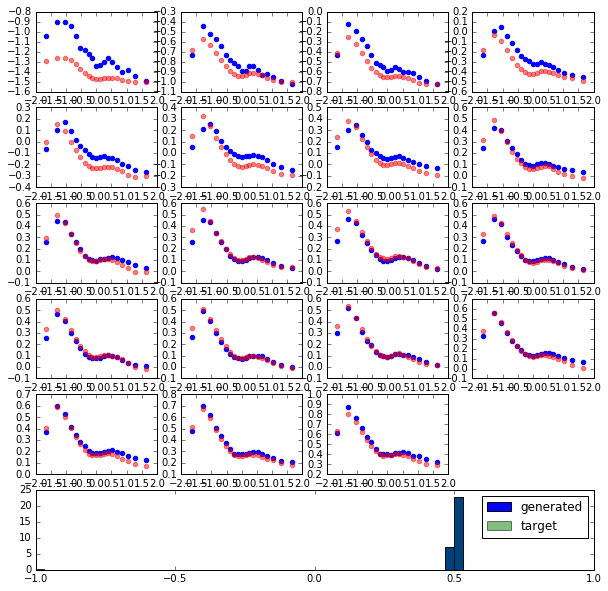

0: D [0.693102 0.503174] A: [0.690416 0.745117]


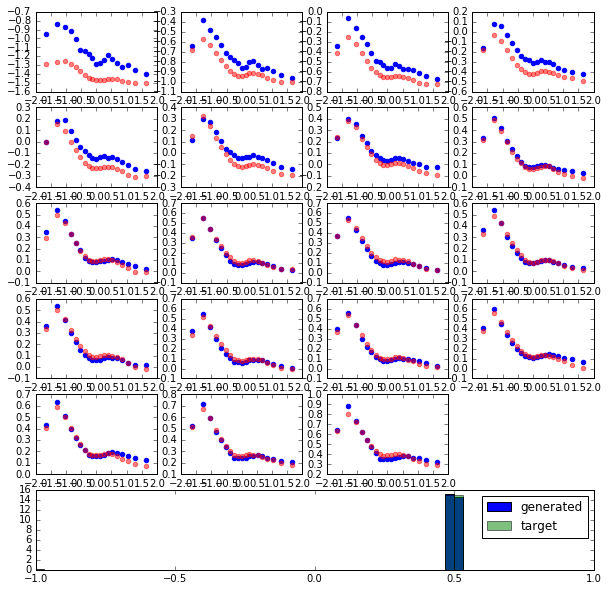

0: D [0.693066 0.503784] A: [0.691071 0.774658]


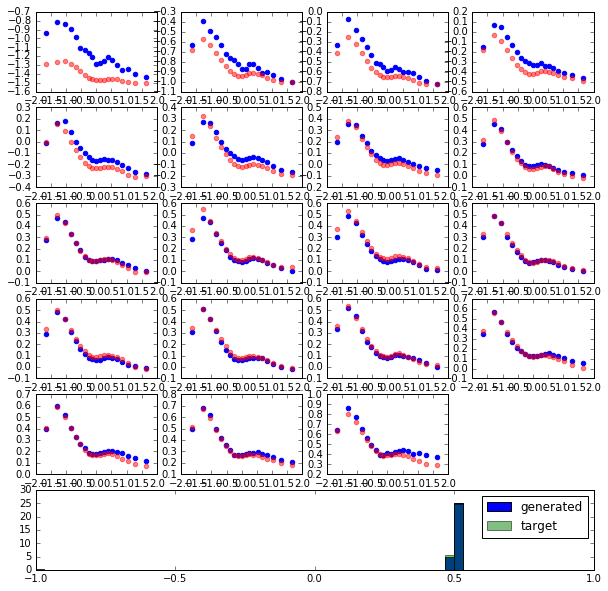

0: D [0.693157 0.498657] A: [0.690287 0.863281]


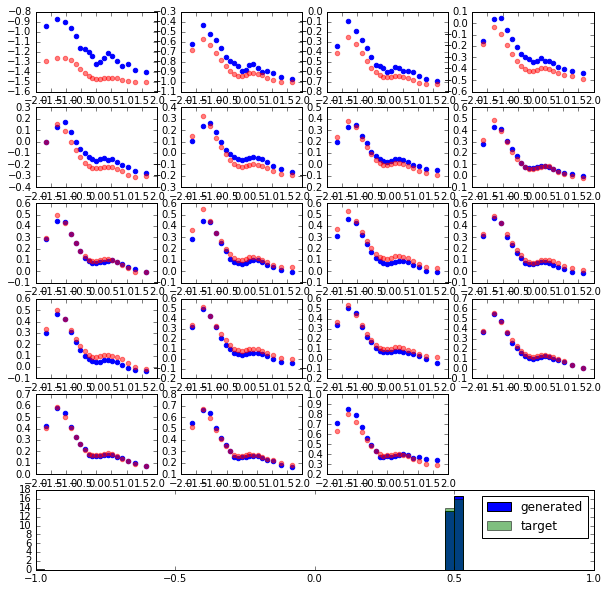

0: D [0.693066 0.505615] A: [0.690288 0.684326]


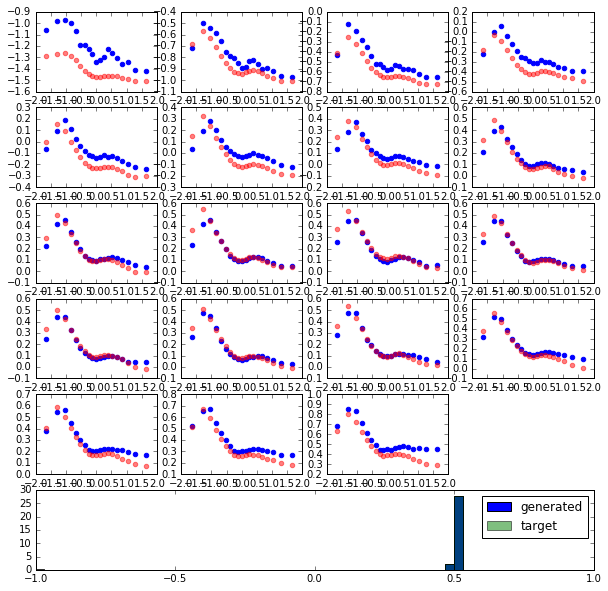

0: D [0.693152 0.494751] A: [0.691837 0.697998]


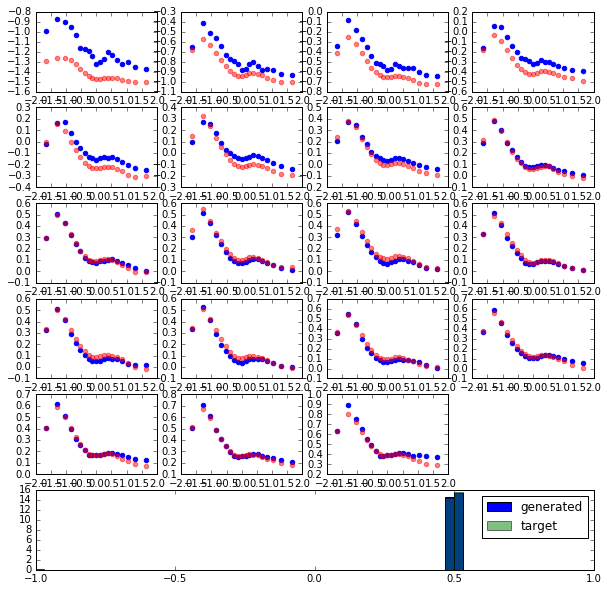

0: D [0.693044 0.504517] A: [0.691387 0.664551]


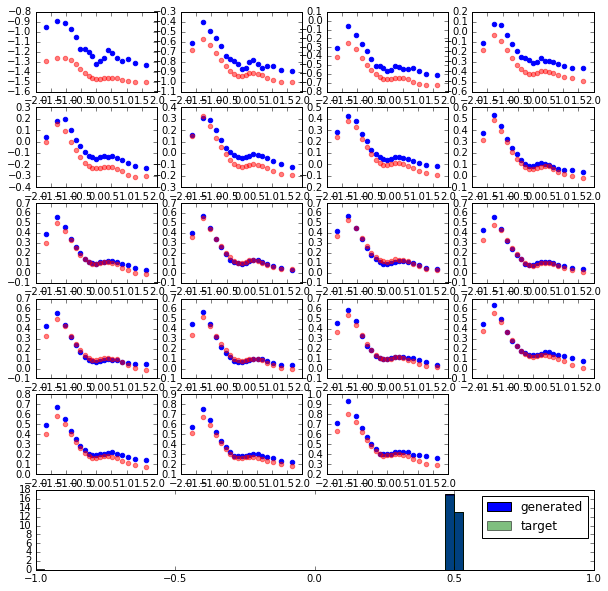

0: D [0.693070 0.503052] A: [0.693218 0.558105]


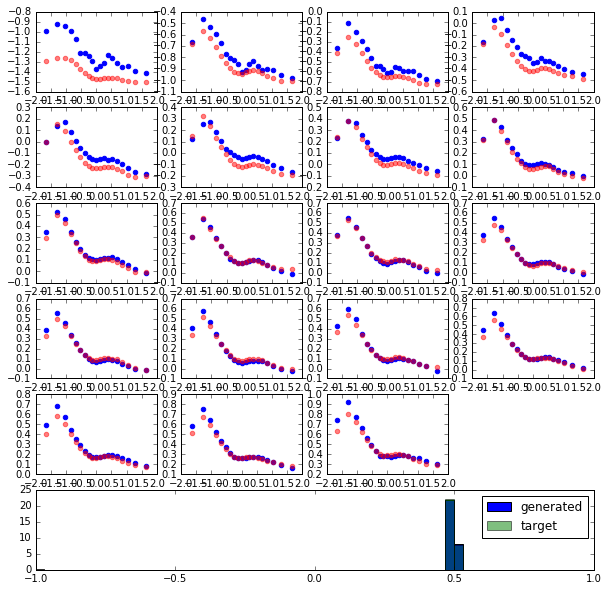

0: D [0.693101 0.502808] A: [0.691834 0.615723]


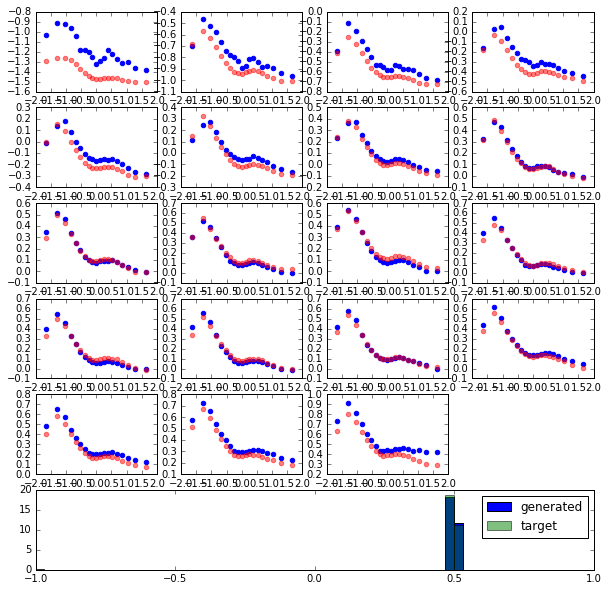

0: D [0.693115 0.504150] A: [0.691154 0.634277]


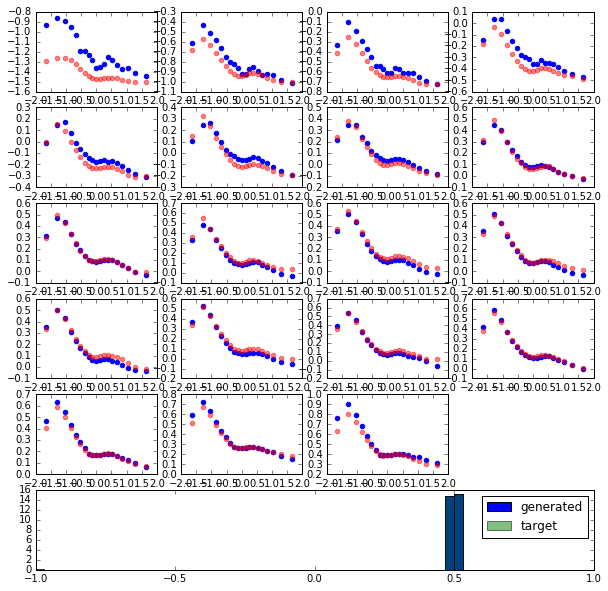

0: D [0.693141 0.495972] A: [0.690331 0.757812]


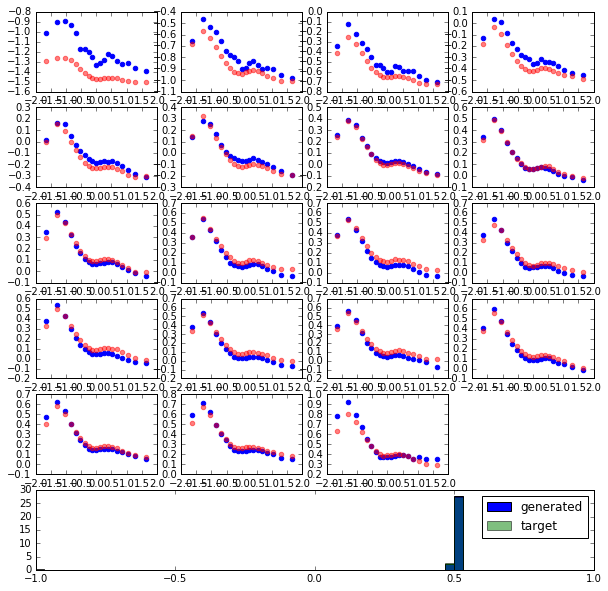

0: D [0.693118 0.498169] A: [0.690280 0.699463]


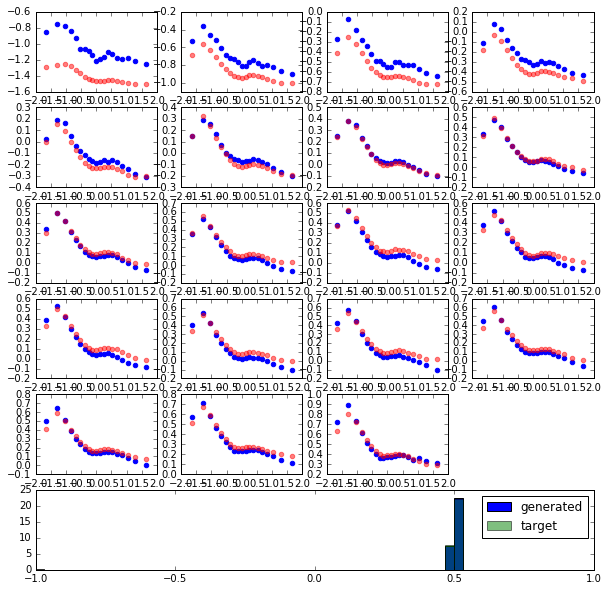

0: D [0.693130 0.499390] A: [0.692249 0.603027]


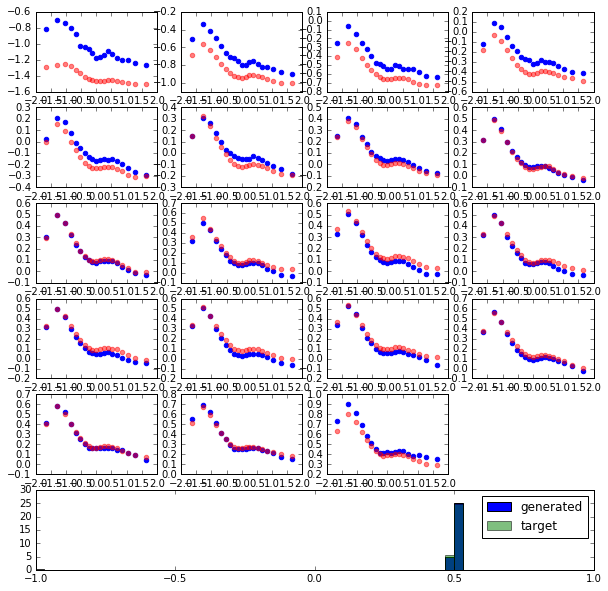

0: D [0.693155 0.501343] A: [0.691690 0.740967]


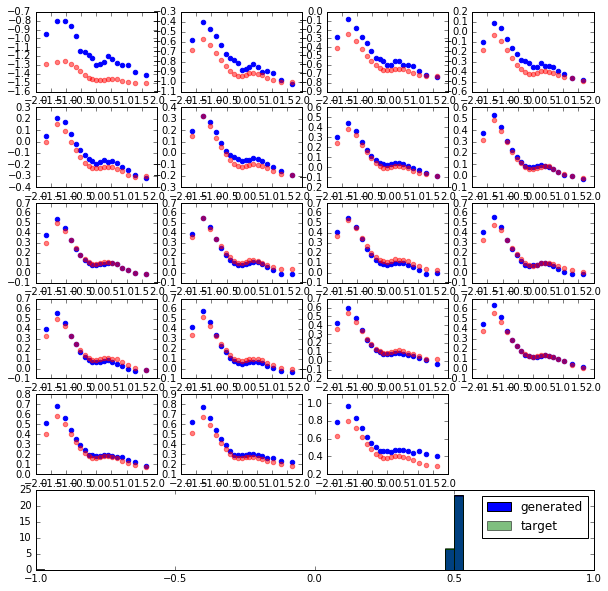

0: D [0.693109 0.502686] A: [0.690493 0.731201]


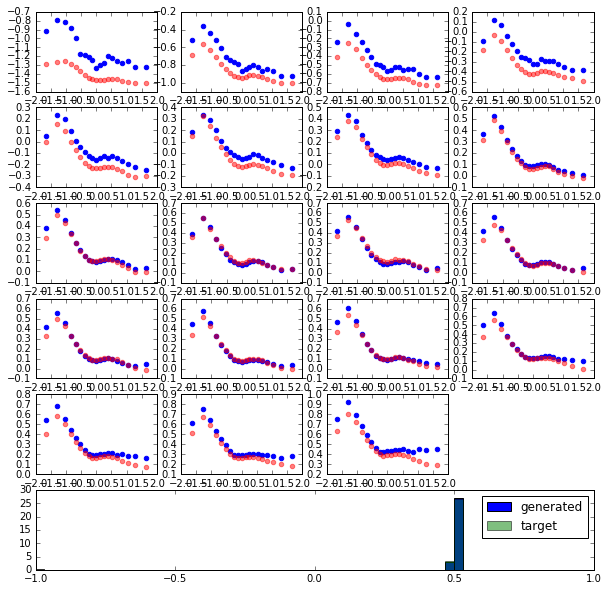

0: D [0.693075 0.508057] A: [0.692904 0.500488]


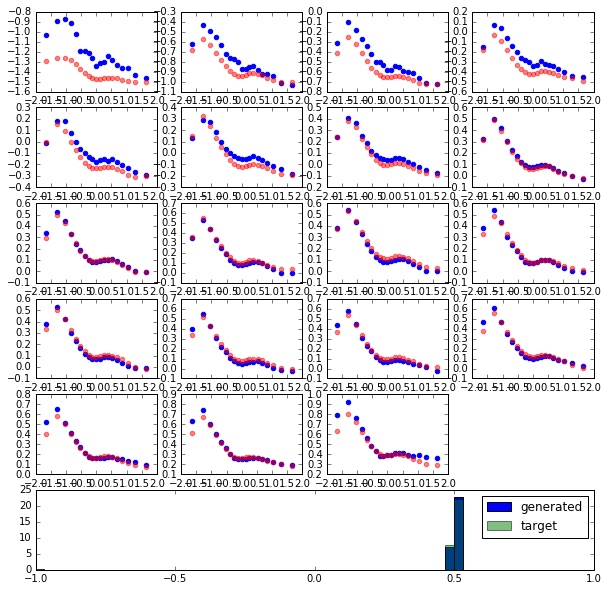

0: D [0.692994 0.513062] A: [0.690371 0.715088]


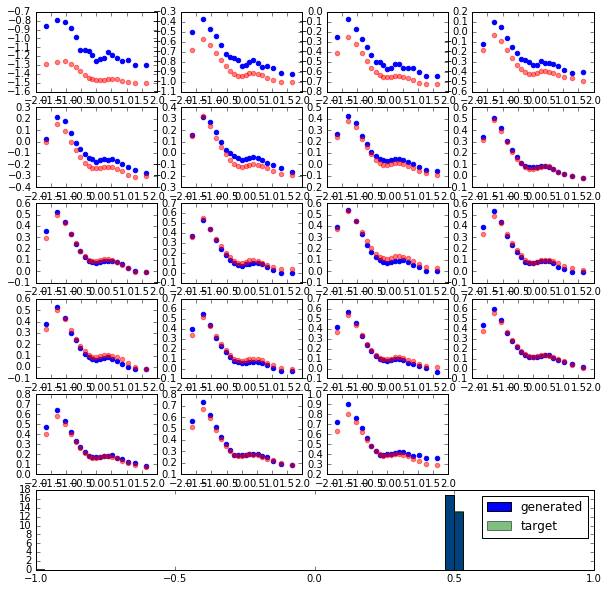

0: D [0.692986 0.502686] A: [0.689962 0.667236]


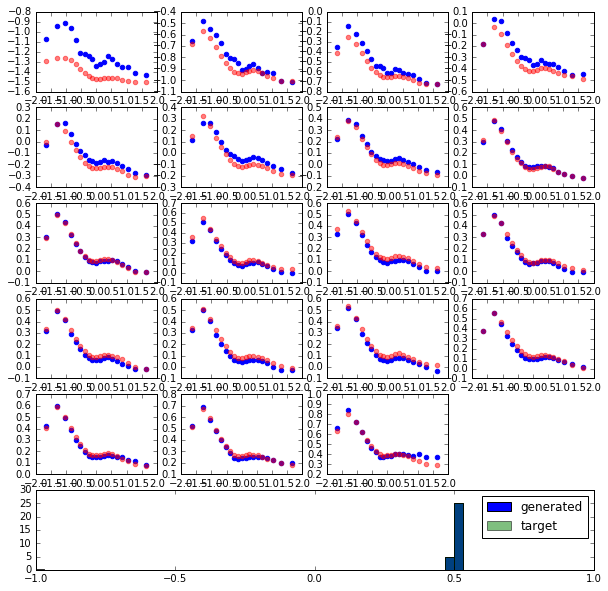

0: D [0.692913 0.511230] A: [0.688018 0.721191]


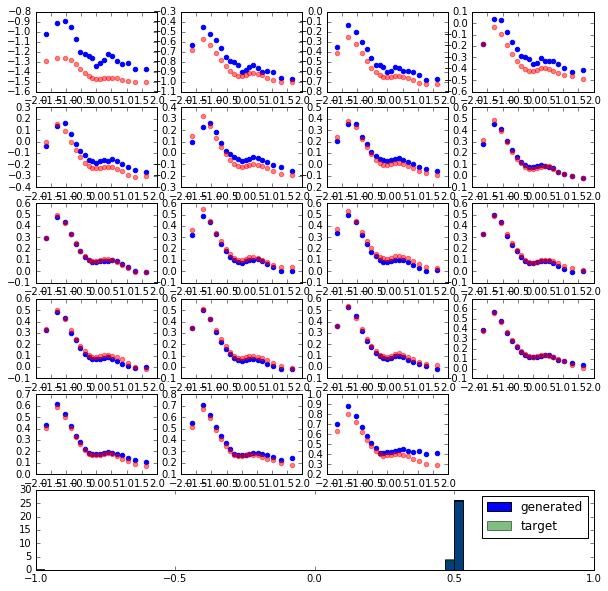

0: D [0.693004 0.505493] A: [0.688014 0.756836]


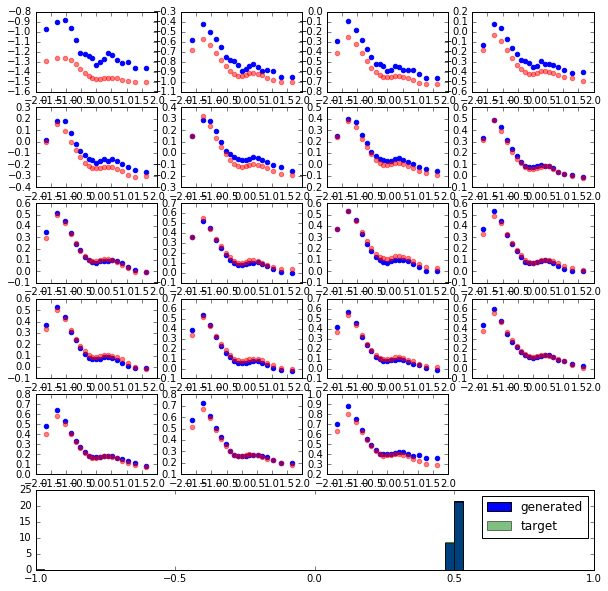

0: D [0.692937 0.512207] A: [0.689096 0.637451]


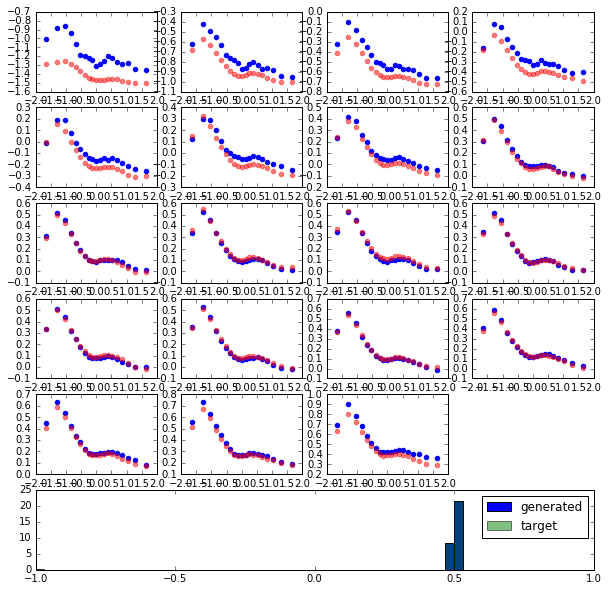

0: D [0.692820 0.506470] A: [0.690700 0.488281]


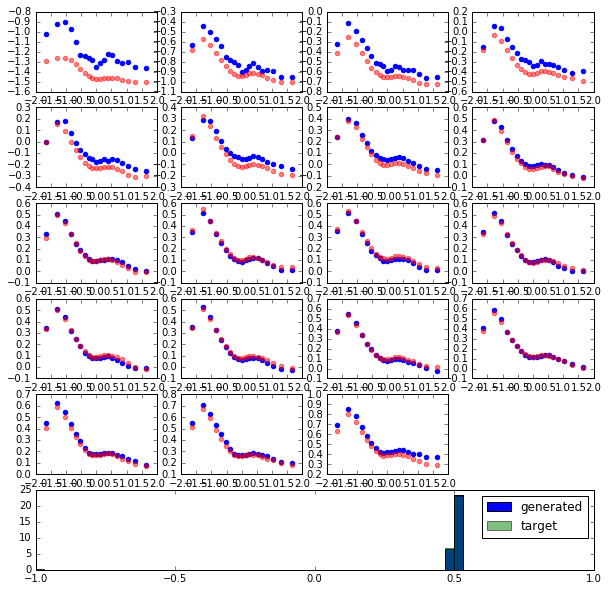

0: D [0.692875 0.506226] A: [0.689692 0.597168]


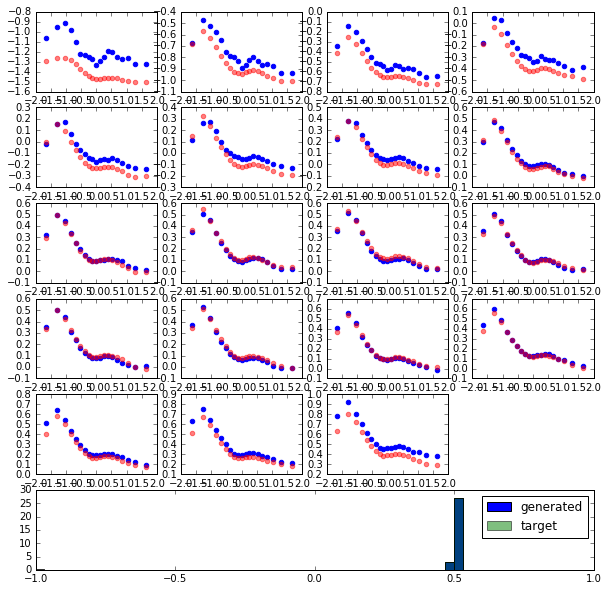

0: D [0.692880 0.513794] A: [0.691374 0.569336]


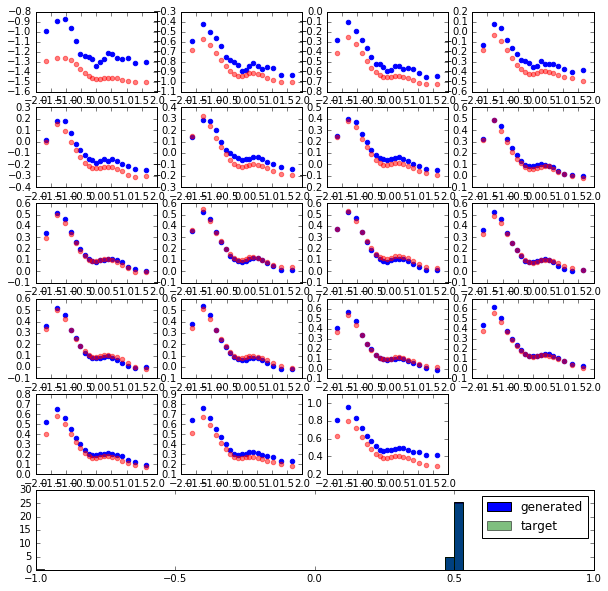

0: D [0.692782 0.518921] A: [0.690954 0.539062]


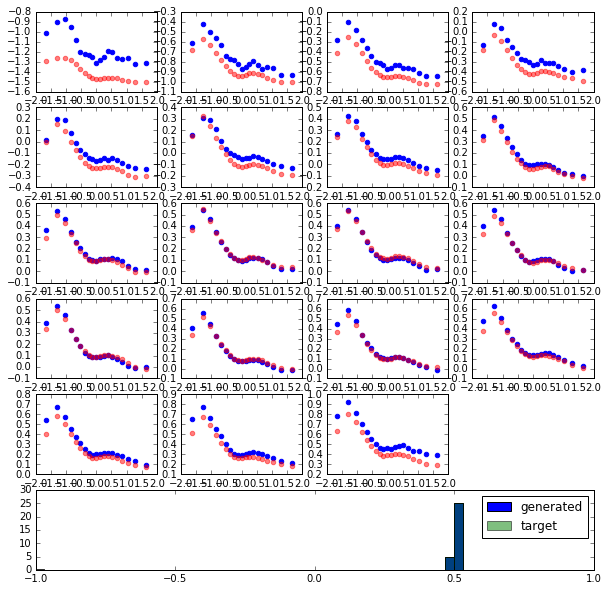

0: D [0.692682 0.517944] A: [0.691352 0.479248]


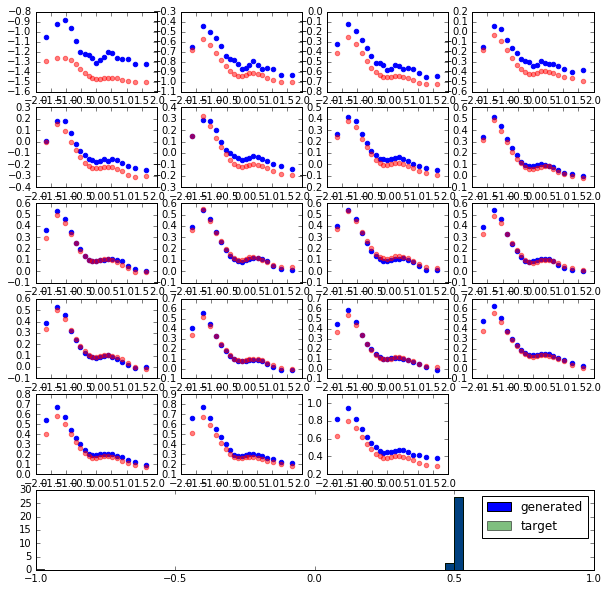

0: D [0.692691 0.515503] A: [0.690777 0.478516]


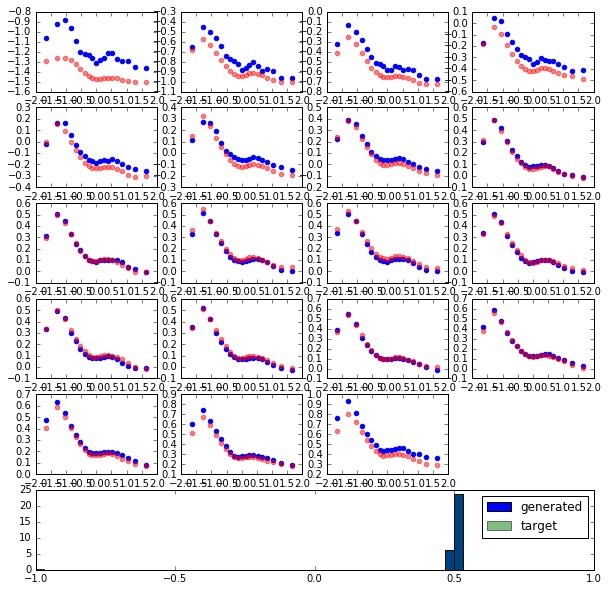

0: D [0.692446 0.509521] A: [0.691201 0.438477]


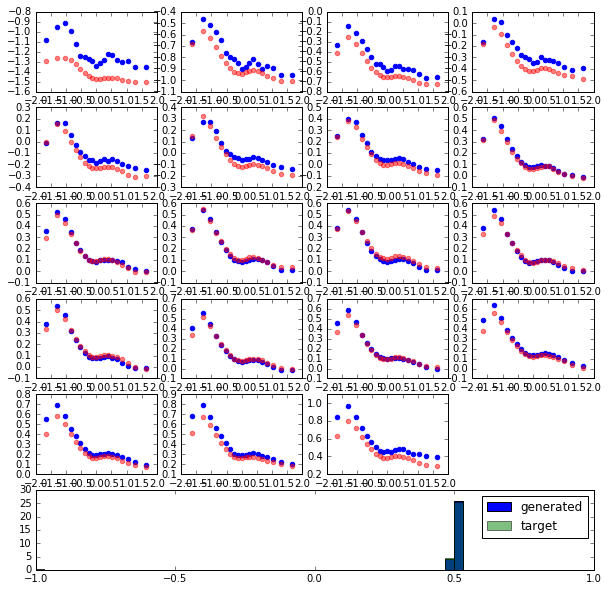

0: D [0.692458 0.515869] A: [0.691519 0.407471]


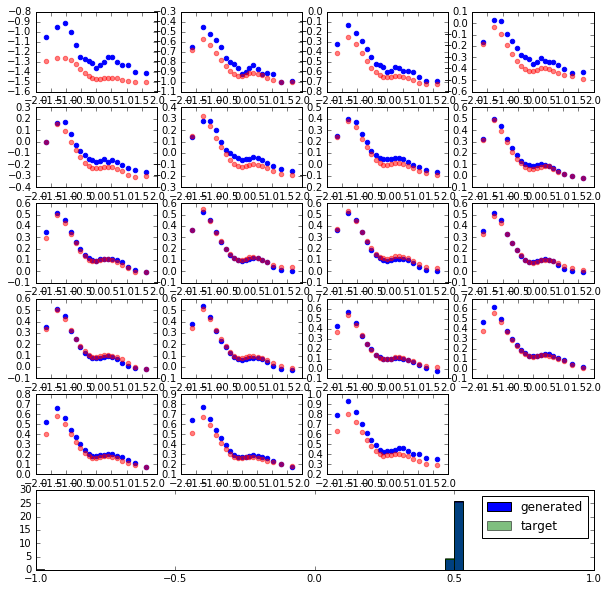

0: D [0.692514 0.506714] A: [0.690109 0.512207]


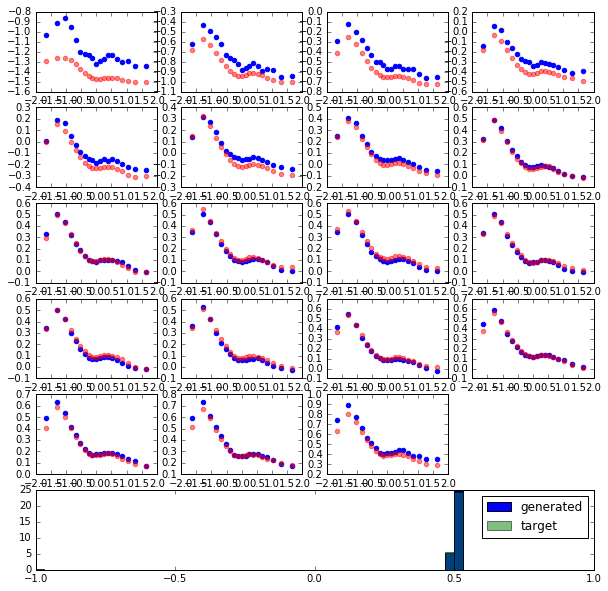

0: D [0.692727 0.513794] A: [0.689333 0.636719]


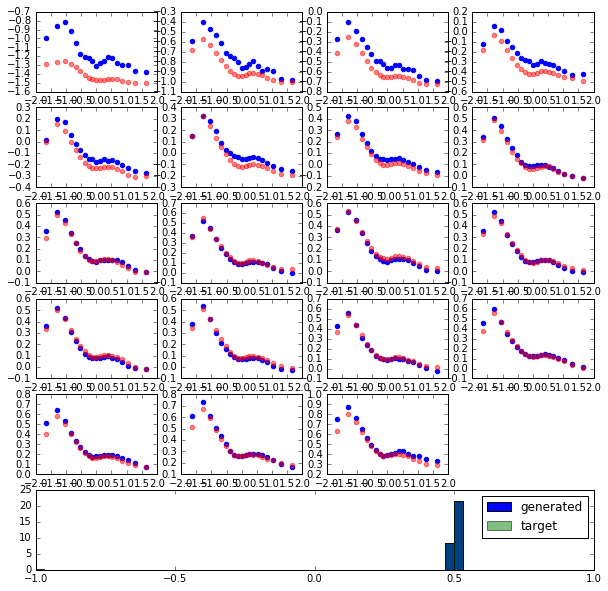

0: D [0.692644 0.512085] A: [0.688403 0.707520]


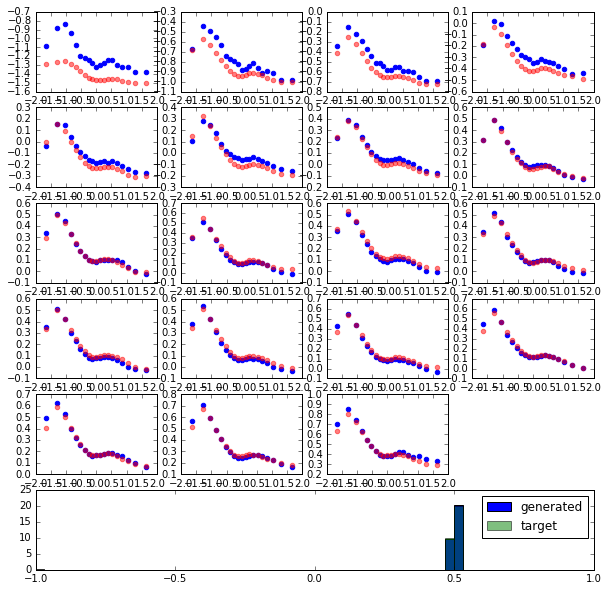

0: D [0.692854 0.506470] A: [0.687235 0.750244]


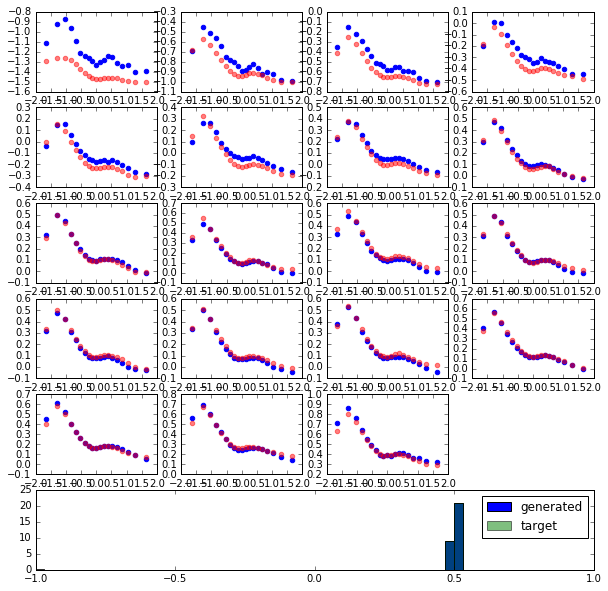

0: D [0.692605 0.512817] A: [0.688867 0.623047]


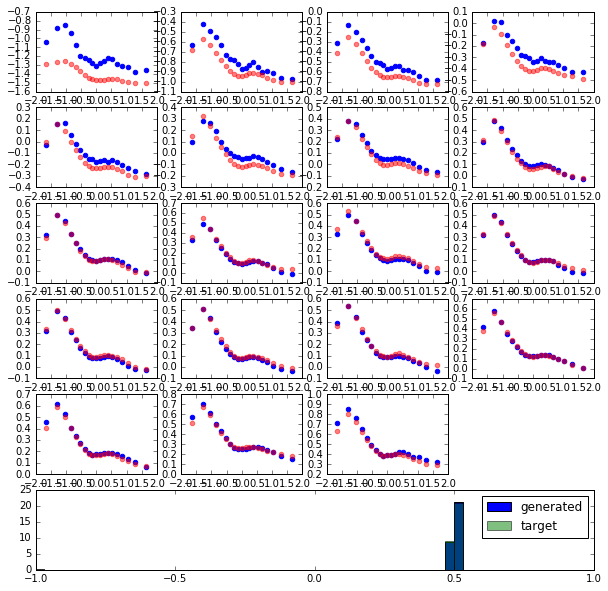

0: D [0.692509 0.511597] A: [0.689226 0.684814]


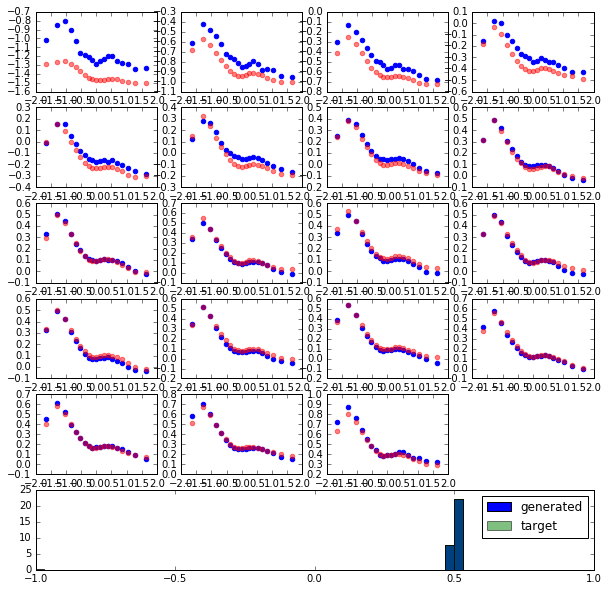

0: D [0.692691 0.510376] A: [0.688940 0.696045]


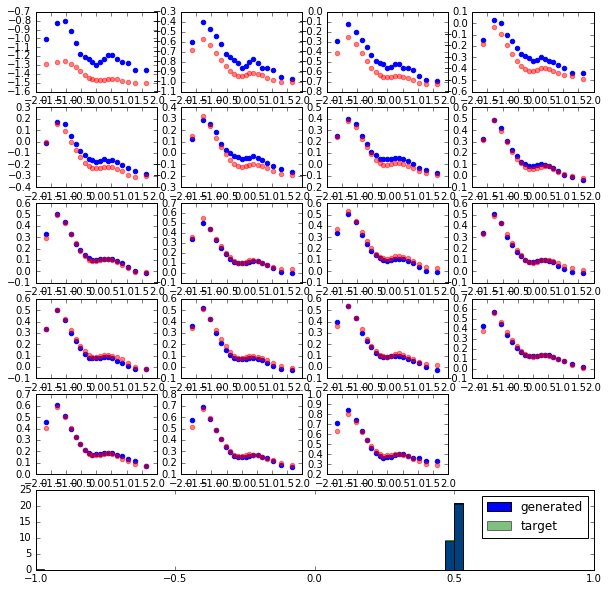

0: D [0.692191 0.514038] A: [0.691004 0.526611]


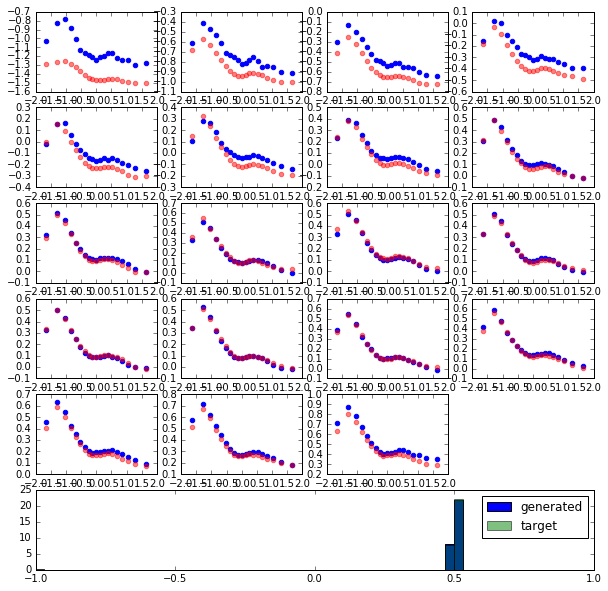

0: D [0.691776 0.514282] A: [0.689939 0.505371]


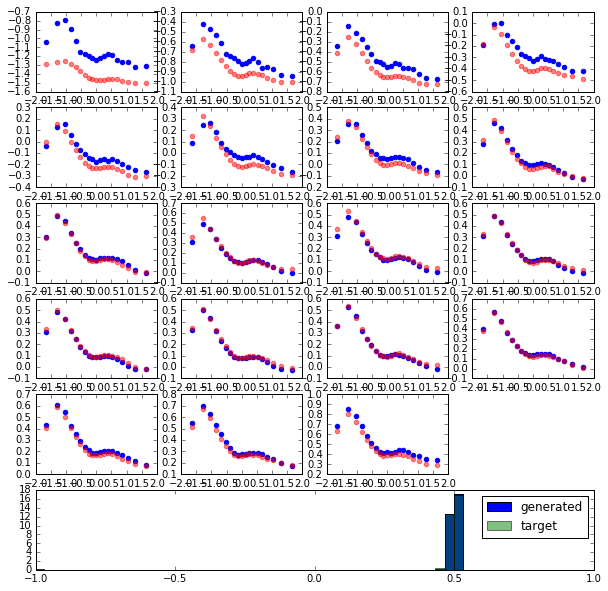

0: D [0.691706 0.514526] A: [0.686563 0.720215]


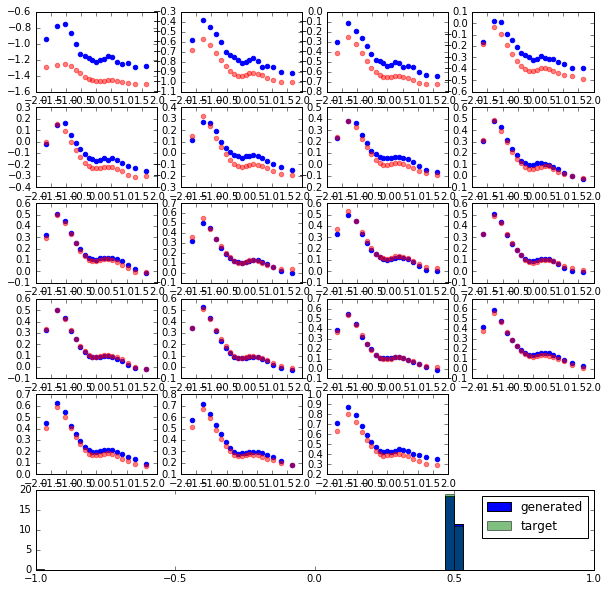

0: D [0.691727 0.514893] A: [0.681541 0.742188]


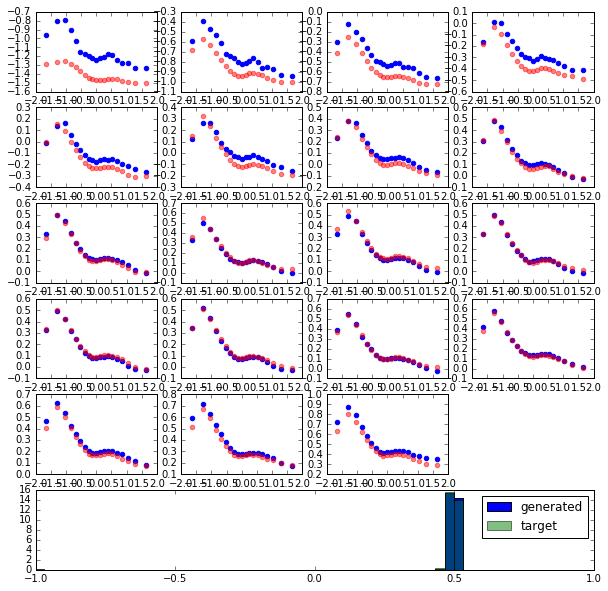

0: D [0.691725 0.515381] A: [0.705864 0.177002]


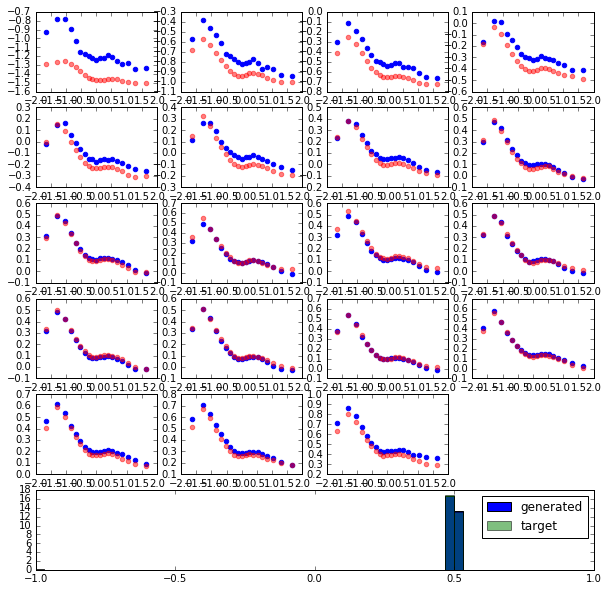

0: D [0.691825 0.520508] A: [0.701099 0.260010]


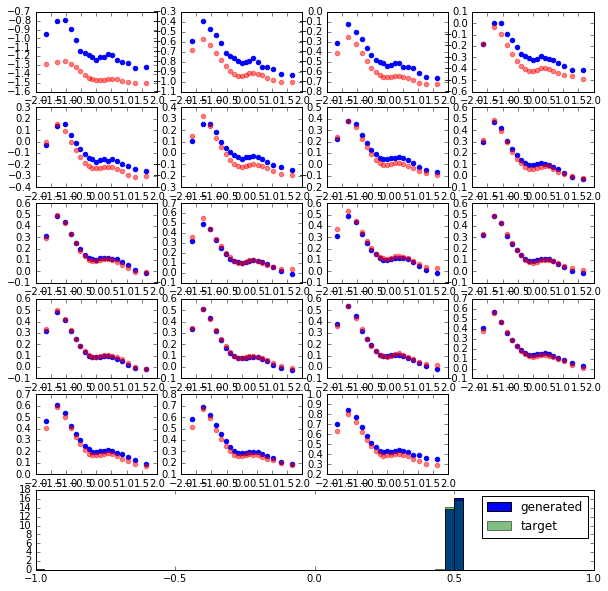

0: D [0.691859 0.512451] A: [0.705168 0.180176]


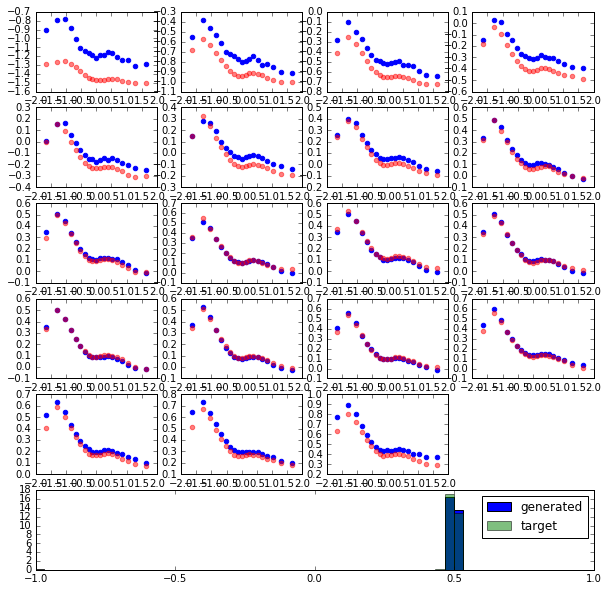

0: D [0.691916 0.512085] A: [0.711350 0.104736]


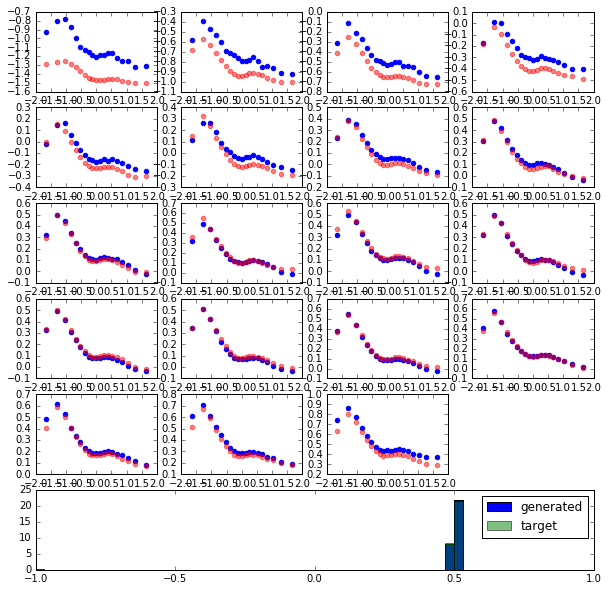

0: D [0.691738 0.521606] A: [0.692333 0.414795]


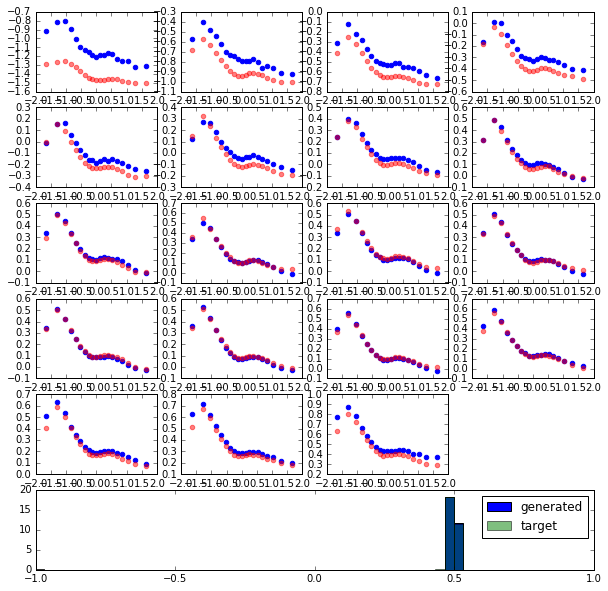

0: D [0.692015 0.508423] A: [0.708089 0.164551]


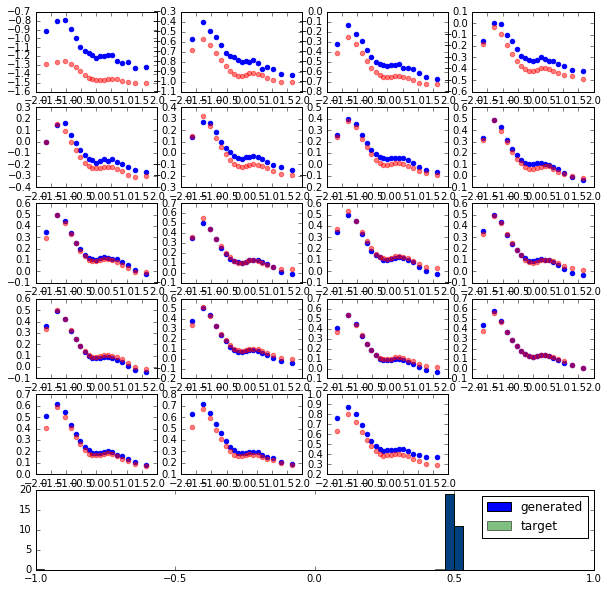

0: D [0.691903 0.507080] A: [0.707592 0.142090]


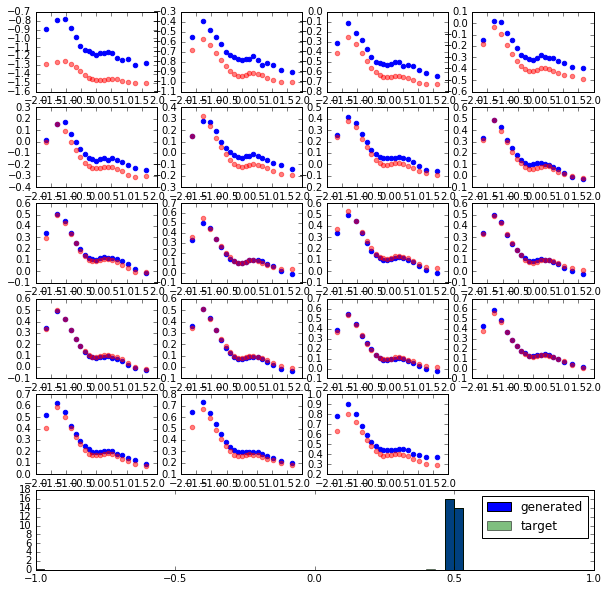

0: D [0.691952 0.509155] A: [0.710064 0.117432]


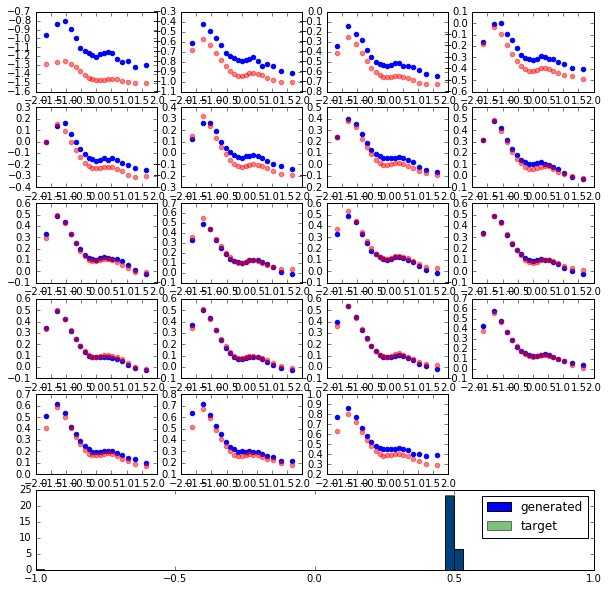

0: D [0.692105 0.511963] A: [0.704025 0.163574]


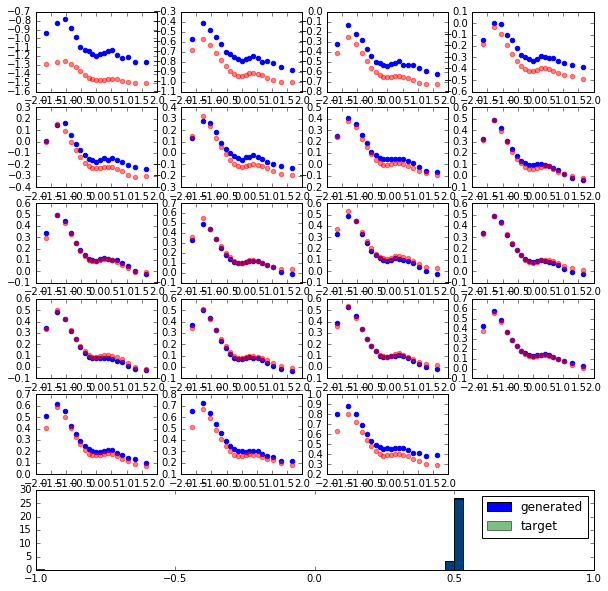

0: D [0.692276 0.513428] A: [0.678262 0.862549]


KeyboardInterrupt: 

In [19]:
probs = np.arange(1,100,1)
cdf_x = np.percentile(x_train,probs)
cdf_z = np.percentile(z_train,probs)


do = dict(x_train=x_train,z_train=z_train,c_x_train=c_train,
        x_test=x_test,z_test=z_test,c_x_test=c_test,
        n_disc_steps=1,n_gen_steps=1,
        n_epochs=20,solution=(cdf_x,cdf_z),plot_every=1,batch_size=4096)

gan.fit(**do)

do.update(dict(n_disc_steps=2))
gan.fit(**do)

do.update(dict(n_disc_steps=3))
gan.fit(**do)

do.update(dict(n_disc_steps=5))
gan.fit(**do)

In [20]:
# c0 = np.random.uniform(-1,1,x.shape)+np.random.normal(0,0.1,x.shape)
# c0 -= c0.mean()
# c0 /= c0.std()

z = toys.white_source(x.shape[0])
# z,_ = toys.two_peaks(x.shape[0],split=False)


g_train = gan.get_generator().predict( [c_train,z] )[1]
# g_test = gan.get_generator().predict( [c_test,z_test] )[1]
# g_test_unique = np.unique(g_test)
# z_test_unique = np.unique(z_test)
# g_test.sort()
# z_test_unique.sort()

In [21]:
# g_quantiles = np.percentile(g,probs_test)
# x_quantiles = np.percentile(x_train,probs_test)

In [22]:
# plt.scatter(z_test_unique,g_quantiles-z_test_unique)
# plt.scatter(z_test_unique,g_test_unique-z_test_unique)
# plt.scatter(z_test_unique,x_quantiles-z_test_unique,color='red')

In [23]:
# plt.scatter(z_test,g_test-z_test)
# plt.scatter(z_test,x_test-z_test,color='red')

In [24]:
# g_quantiles - g_test

In [25]:
target = np.hstack( [c_train.reshape(-1,1), x_train.reshape(-1,1)] )
generated = np.hstack( [c_train.reshape(-1,1), g_train.reshape(-1,1)] )


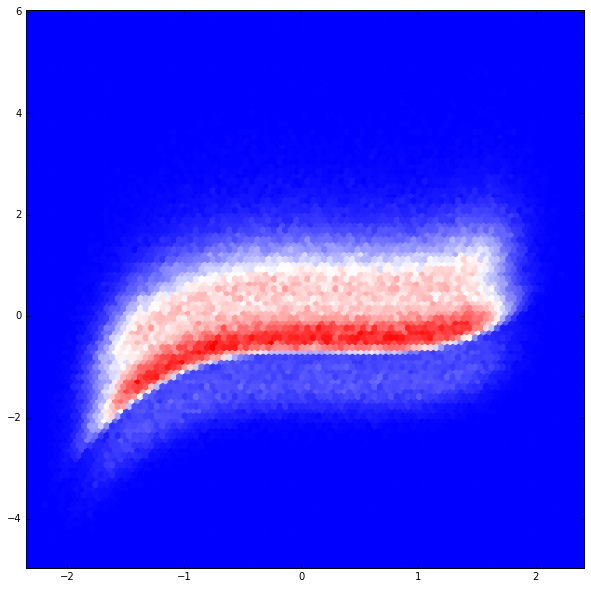

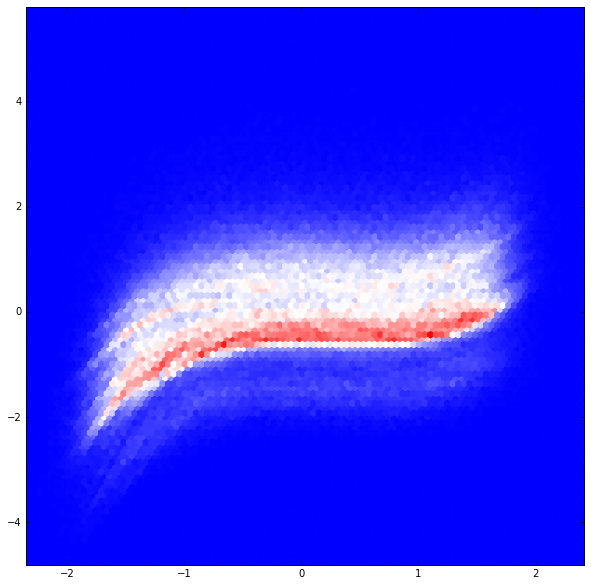

In [26]:
plt.hexbin( c_train.ravel(), x_train.ravel() )
plt.show()

plt.hexbin( c_train.ravel(), g_train.ravel() )
plt.show()


In [27]:
probs2 = [0,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
c_quantiles = np.percentile(np.vstack([generated[:,0],target[:,0]]),probs2)

print(c_quantiles)

[ -2.34869080e+00  -1.36704910e+00  -1.19537421e+00  -1.02439004e+00
  -8.53869628e-01  -6.84000661e-01  -5.13323402e-01  -3.42051526e-01
  -1.69514914e-01  -3.76458965e-05   1.71023577e-01   3.41809381e-01
   5.11552092e-01   6.82244014e-01   8.52882366e-01   1.02326304e+00
   1.19379071e+00   1.36758402e+00   1.55493608e+00   2.41294934e+00]


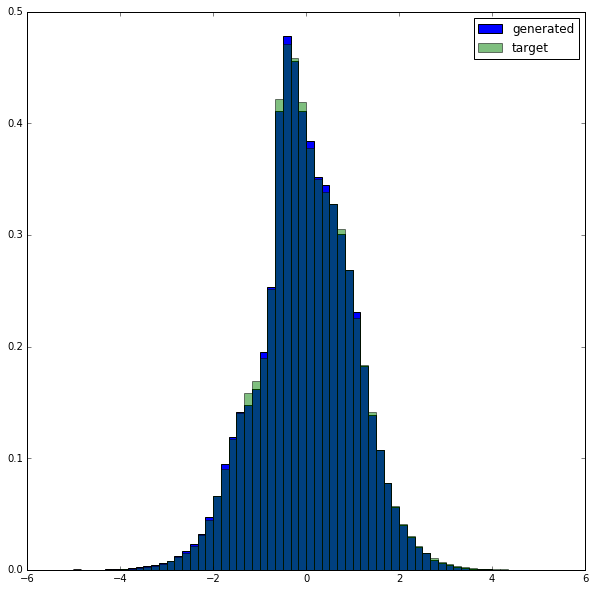

(-2.3486907976448577, -1.3670491044227209, -56850.873174932181, -58039.898576144129)


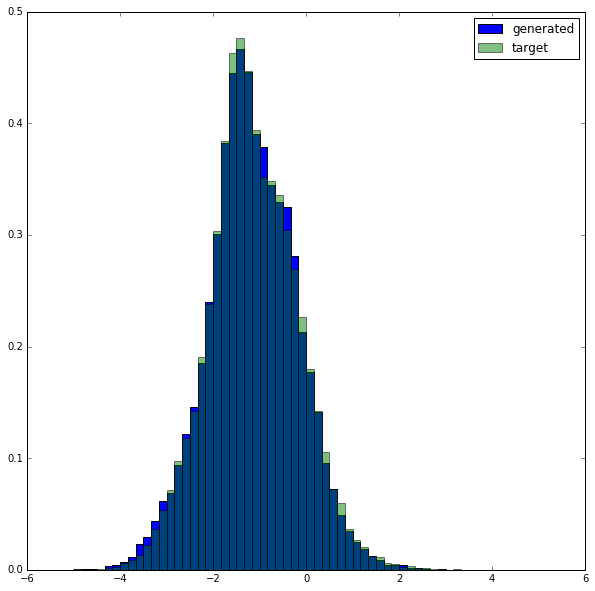

(-1.3670491044227209, -1.1953742111255261, -14451.368218560299, -14813.180897738785)


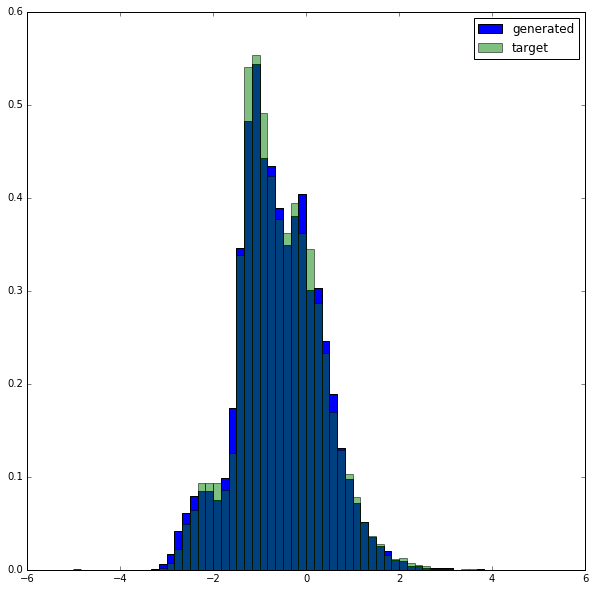

(-1.1953742111255261, -1.0243900357062676, -8500.5747257011699, -8836.7785907164216)


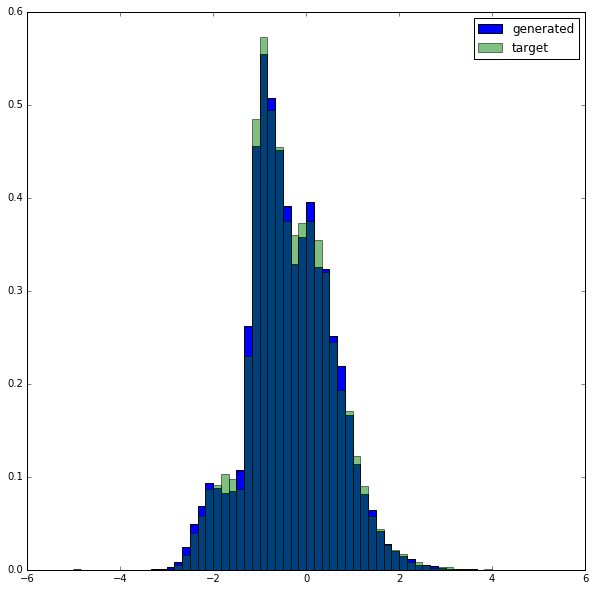

(-1.0243900357062676, -0.8538696283315077, -4007.2533964938184, -4227.3263264019042)


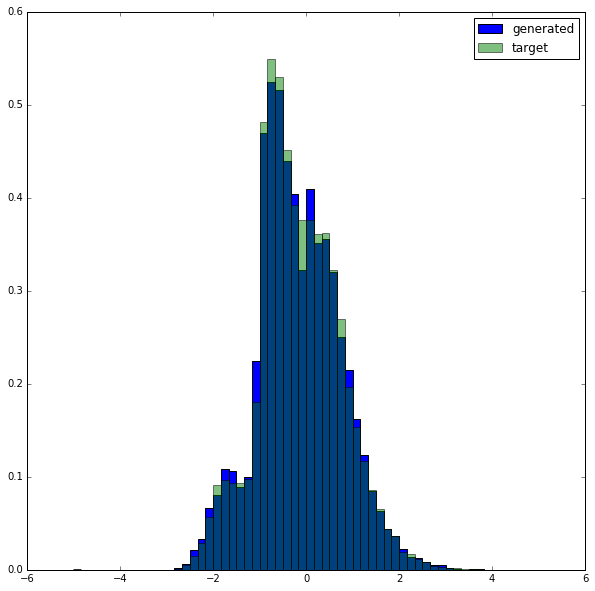

(-0.8538696283315077, -0.68400066083755007, -781.91456738597094, -1024.659231685102)


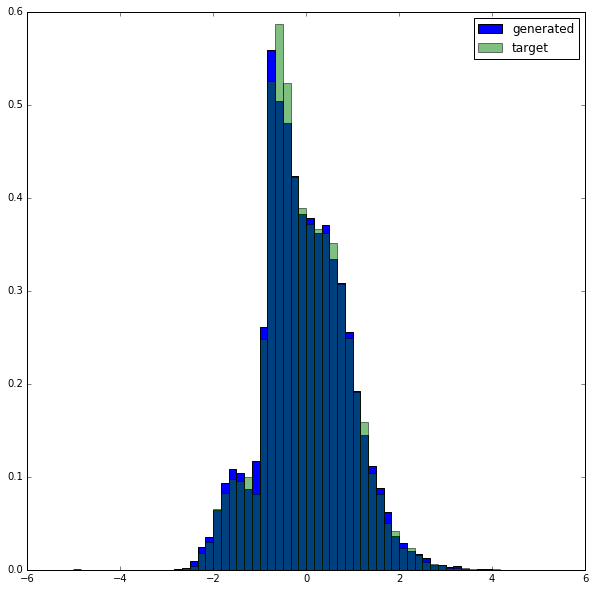

(-0.68400066083755007, -0.51332340154910061, 1774.3587682032039, 1283.8628149162978)


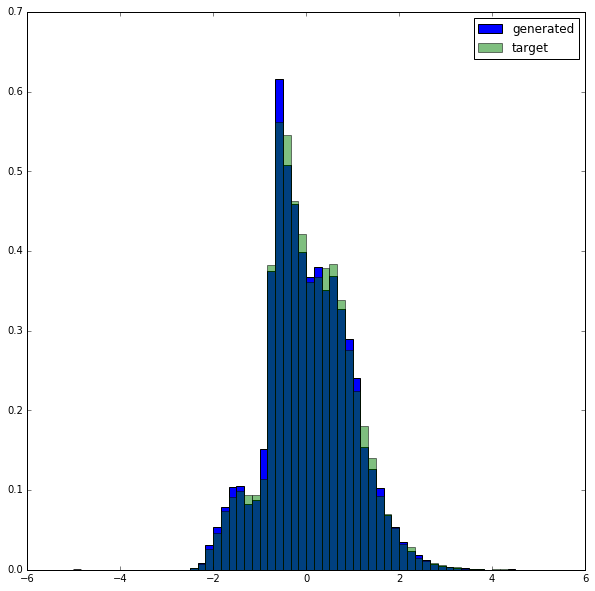

(-0.51332340154910061, -0.34205152599774757, 3531.4273303213859, 3545.7931554242969)


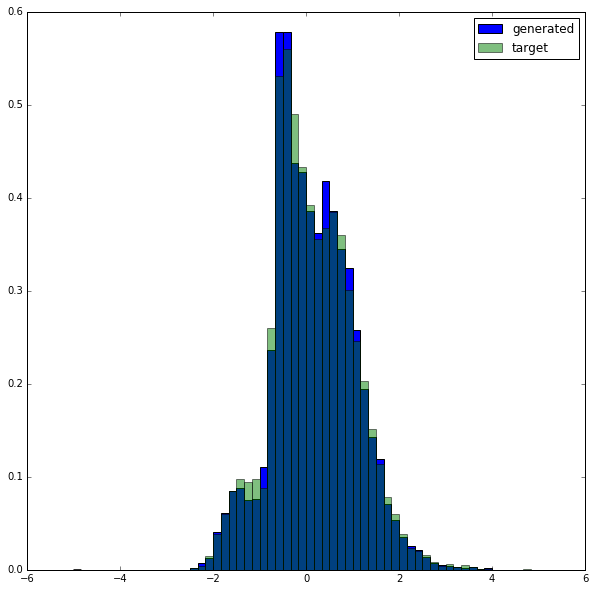

(-0.34205152599774757, -0.169514914419092, 4068.150823781139, 4341.6330369058996)


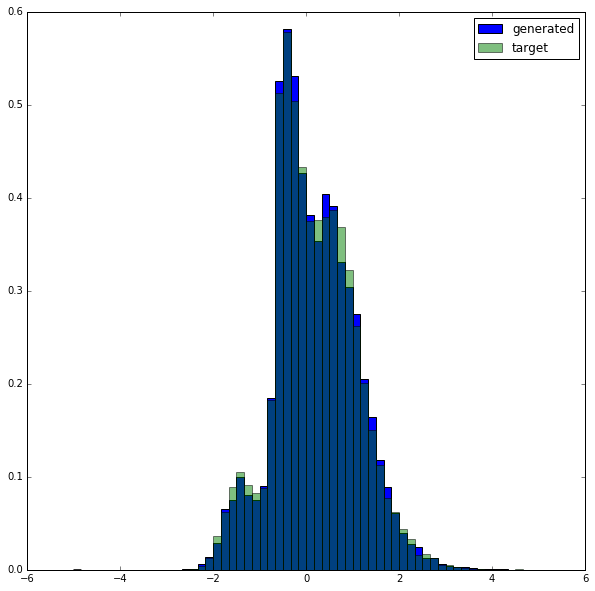

(-0.169514914419092, -3.7645896473803465e-05, 4703.9863951144607, 4562.2733360566199)


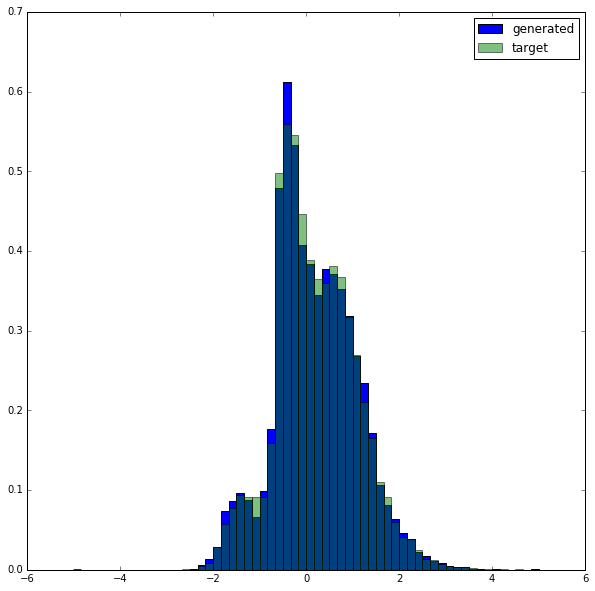

(-3.7645896473803465e-05, 0.17102357738623991, 4804.5552571137387, 4315.9970184806734)


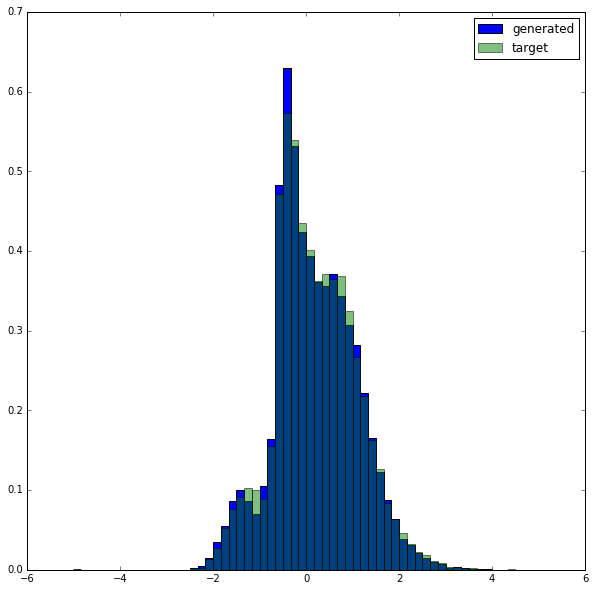

(0.17102357738623991, 0.34180938097711122, 4193.8629007405962, 4271.7323009930551)


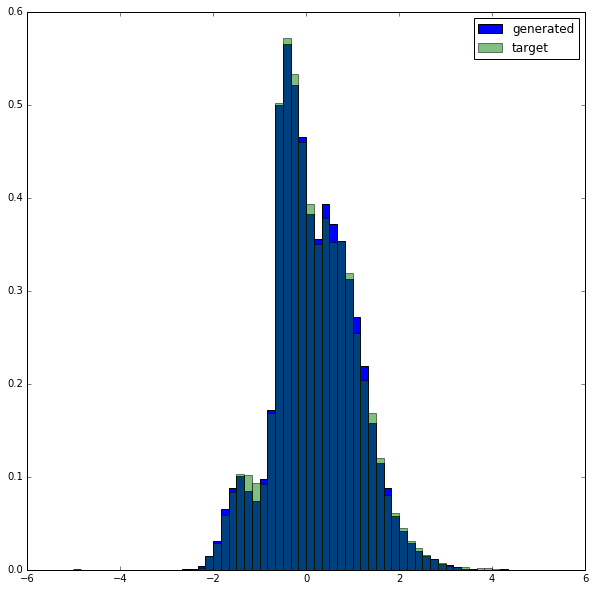

(0.34180938097711122, 0.51155209186169492, 4127.6249506218519, 4039.7234472204)


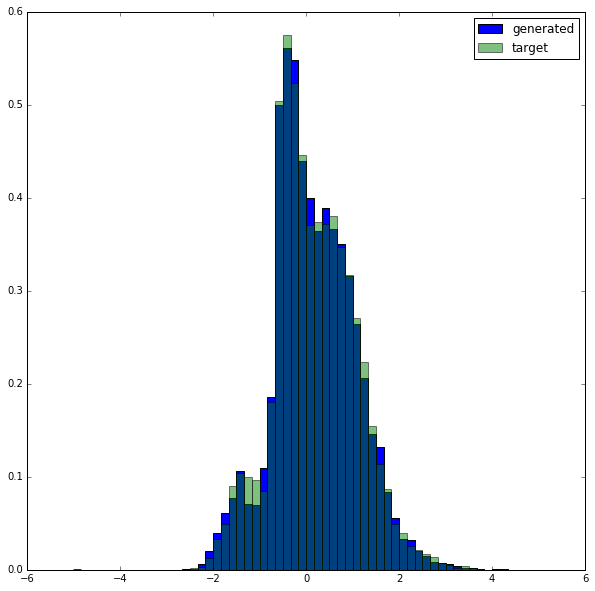

(0.51155209186169492, 0.68224401350797725, 4072.8501284809154, 4009.1710040774196)


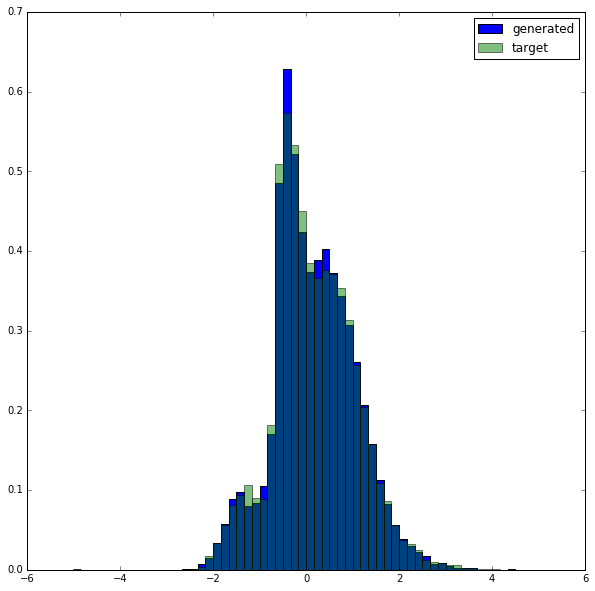

(0.68224401350797725, 0.85288236612233603, 4416.520616934753, 4277.3237146101892)


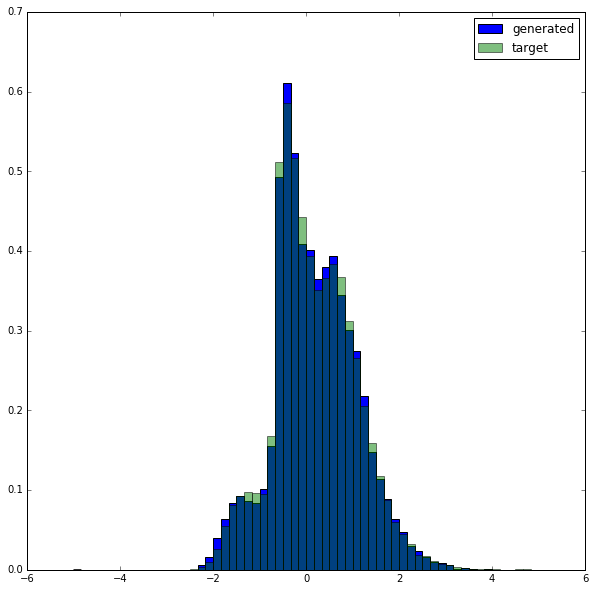

(0.85288236612233603, 1.0232630359933923, 4978.8122268150955, 5146.4340495187789)


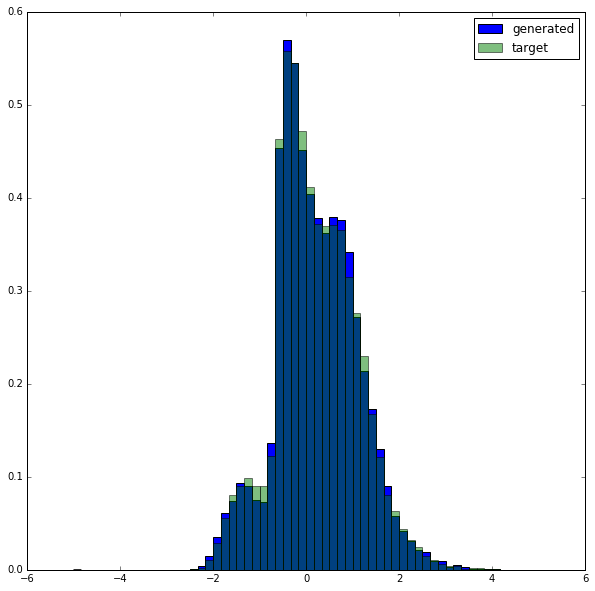

(1.0232630359933923, 1.193790714634281, 6060.124228951363, 6292.0637603532523)


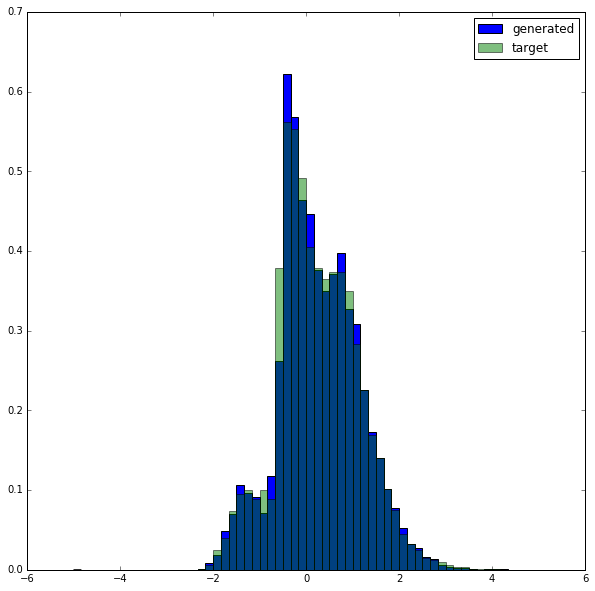

(1.193790714634281, 1.3675840165319328, 8431.0728181922059, 8254.6651316285133)


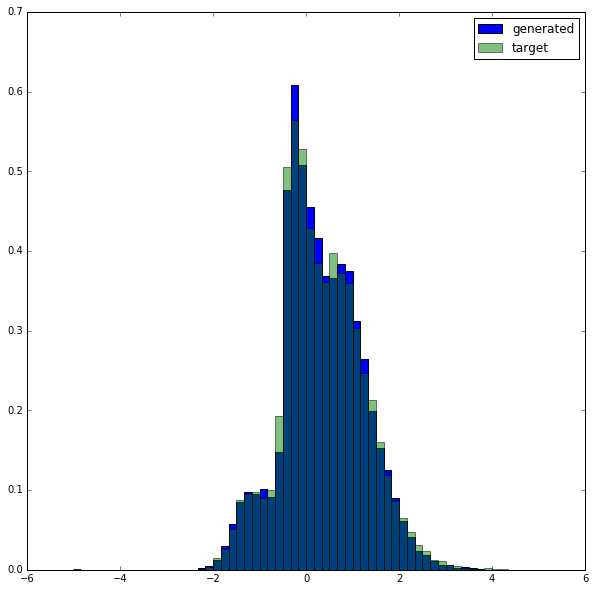

(1.3675840165319328, 1.554936083083575, 11533.122341091841, 11029.752862704918)


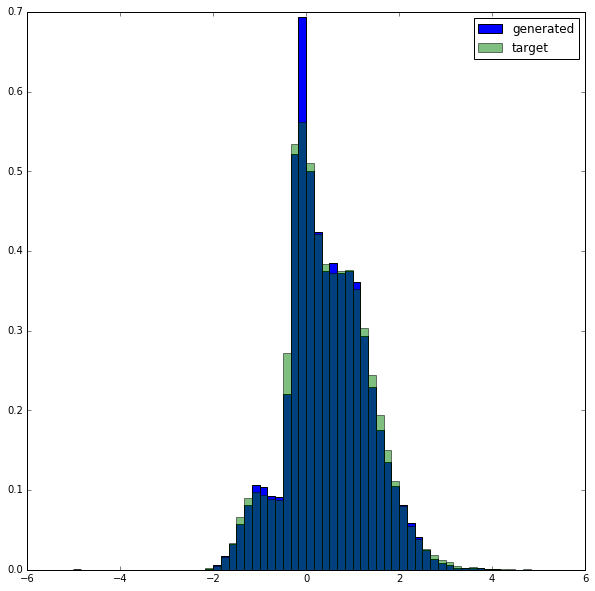

(1.554936083083575, 2.4129493414825616, 17899.578941664728, 17514.966780686751)


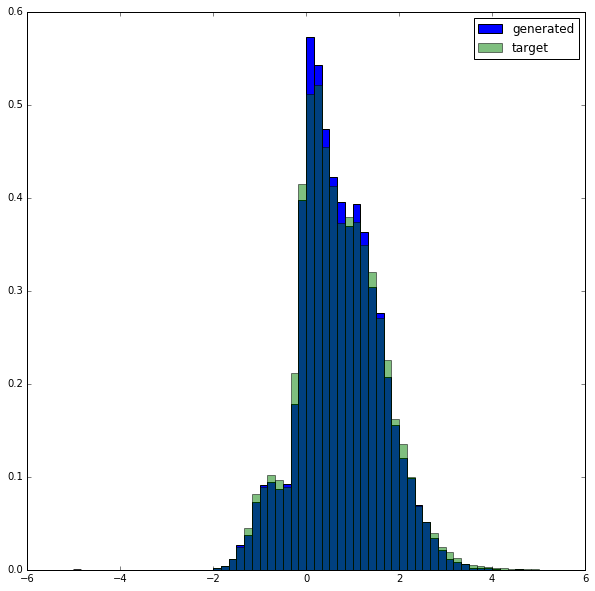

In [28]:
plotting.plot_hists(target[:,1],generated[:,1])
plt.show()

for iqt in range(c_quantiles.shape[0]-1):
    q0 = c_quantiles[iqt]
    q1 = c_quantiles[iqt+1]
    target_slice = target[:,1][(target[:,0]>q0) & (target[:,0]<=q1)] 
    generated_slice = generated[:,1][(generated[:,0]>q0) & (generated[:,0]<=q1)]
    
    print(q0, q1, target_slice.sum(), generated_slice.sum() )
    #target_q = np.percentile( [ target_slice ] , probs2  )
    #generated_q = np.percentile( [ generated_slice ], probs2  )
    
    #plt.plot(target_q,generated_q-target_q,label='%d' % probs2[iqt+1])

    plotting.plot_hists(target_slice,generated_slice)
    plt.show()
#plt.legend()
#plt.show()

In [39]:
gan.am.output

sigmoid.0